In [2]:
import pyPyrTools as ppt
import sys
import numpy as np
sys.path.append('..')
import sfp
%matplotlib inline
import seaborn as sns
from pyPyrTools import JBhelpers as jbh
import pandas as pd
from scipy import signal
import fractions

The following demonstrates some of the stimuli that can be made with the `log_polar_grating` command. The key characteristic of these stimuli is that the frequency (in cycles per pixel) increases as you approach the center of the image. This encodes our hypothesis that the preferred spatial frequency of neurons (and thus, voxels) whose receptive fields are located at the fovea (here, the center of the image) will have a higher preferred spatial frequency than those whose receptive fields are located in the periphery.

However, with these parameters, we notice that there is strange-looking aliasing happening in the center of the image.


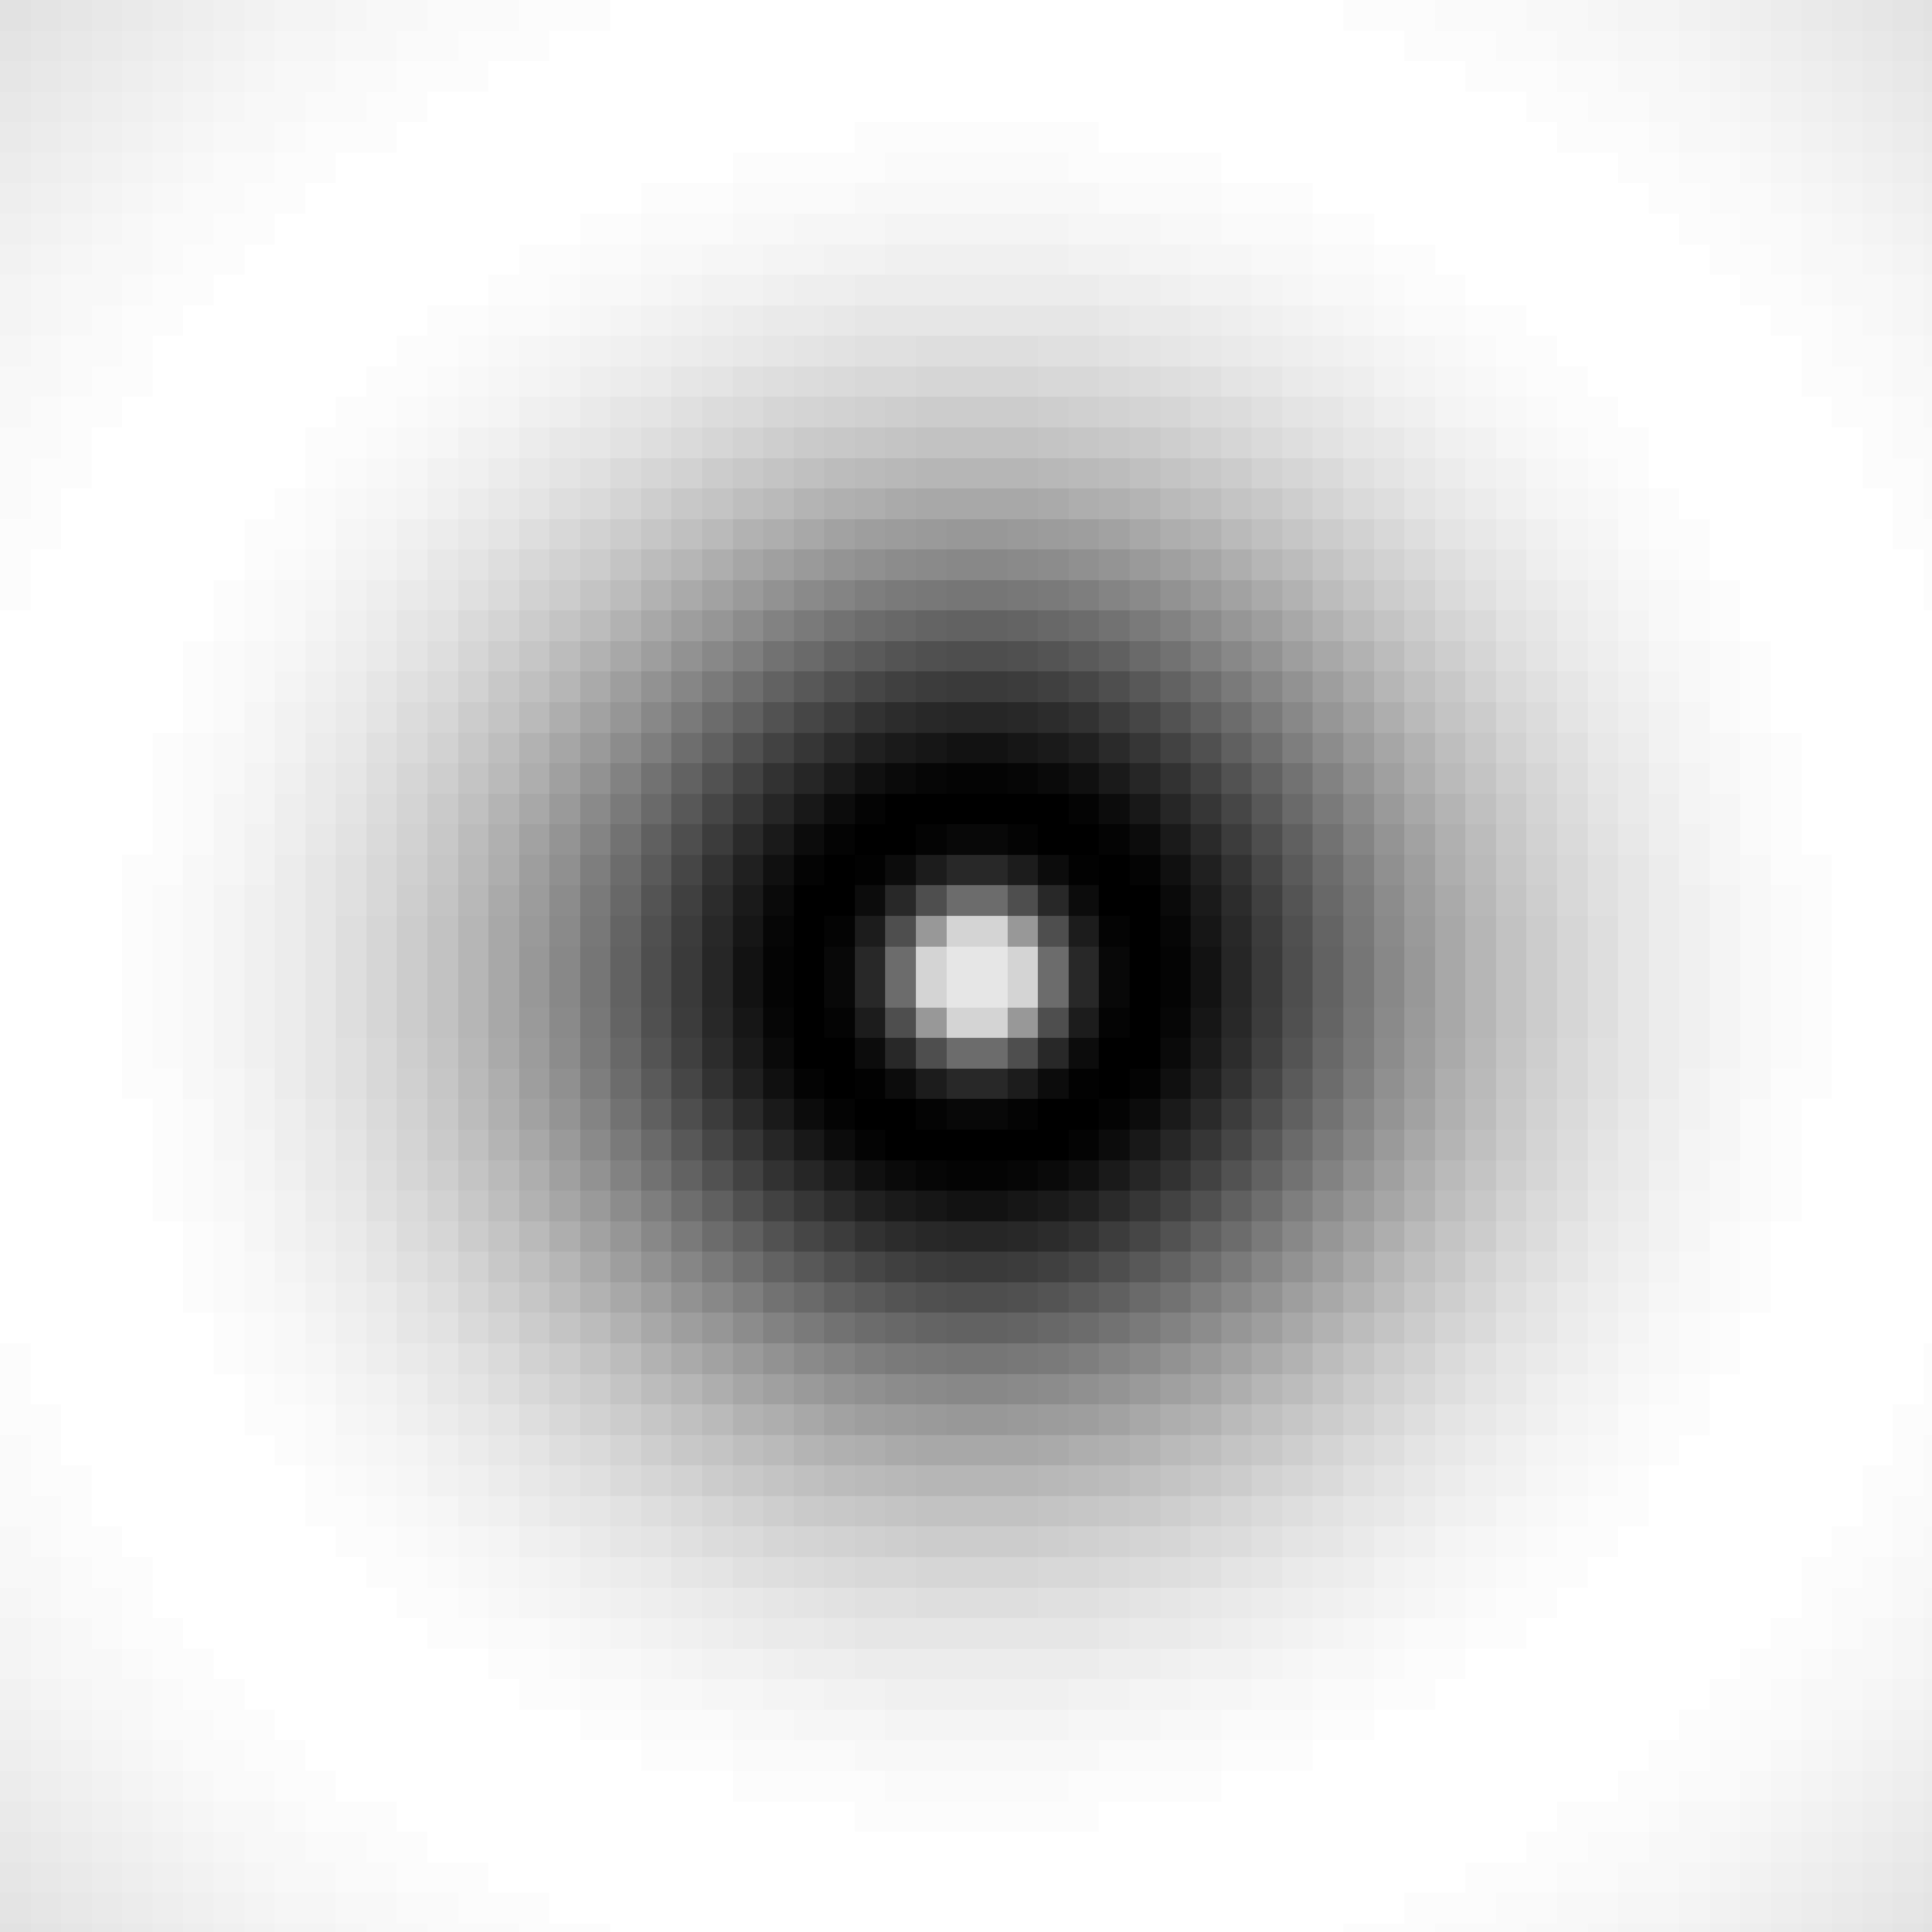
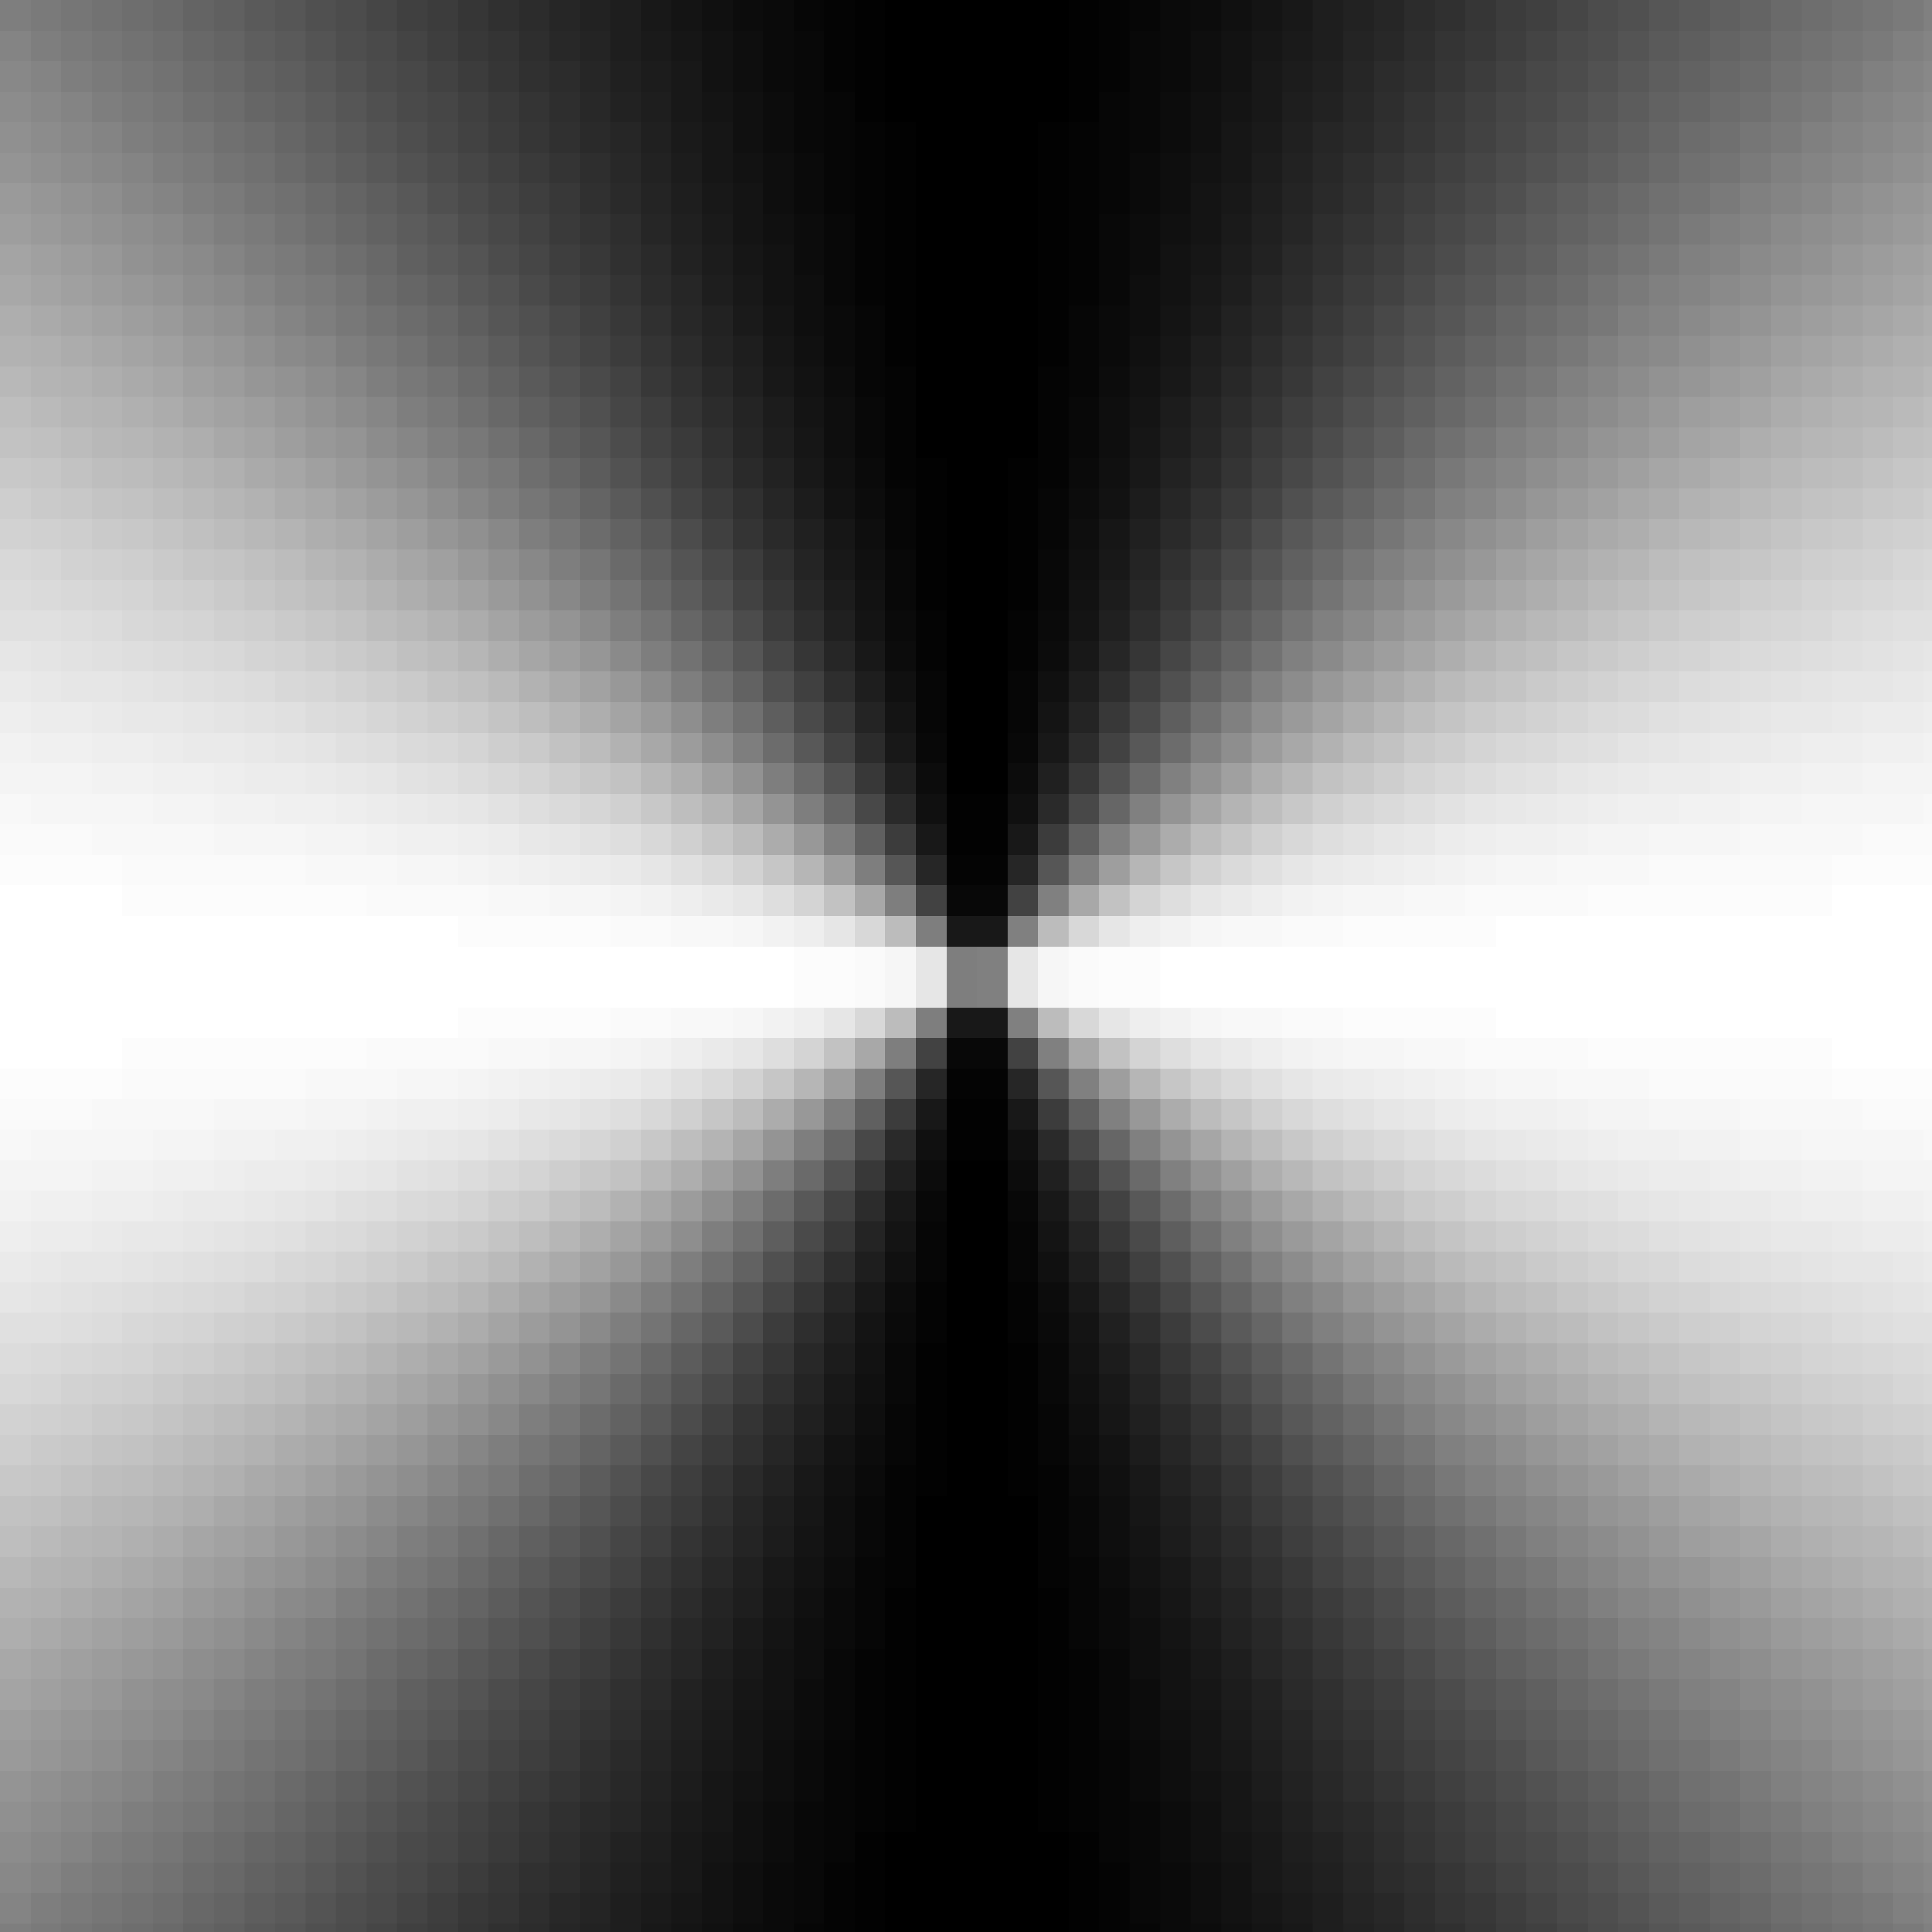
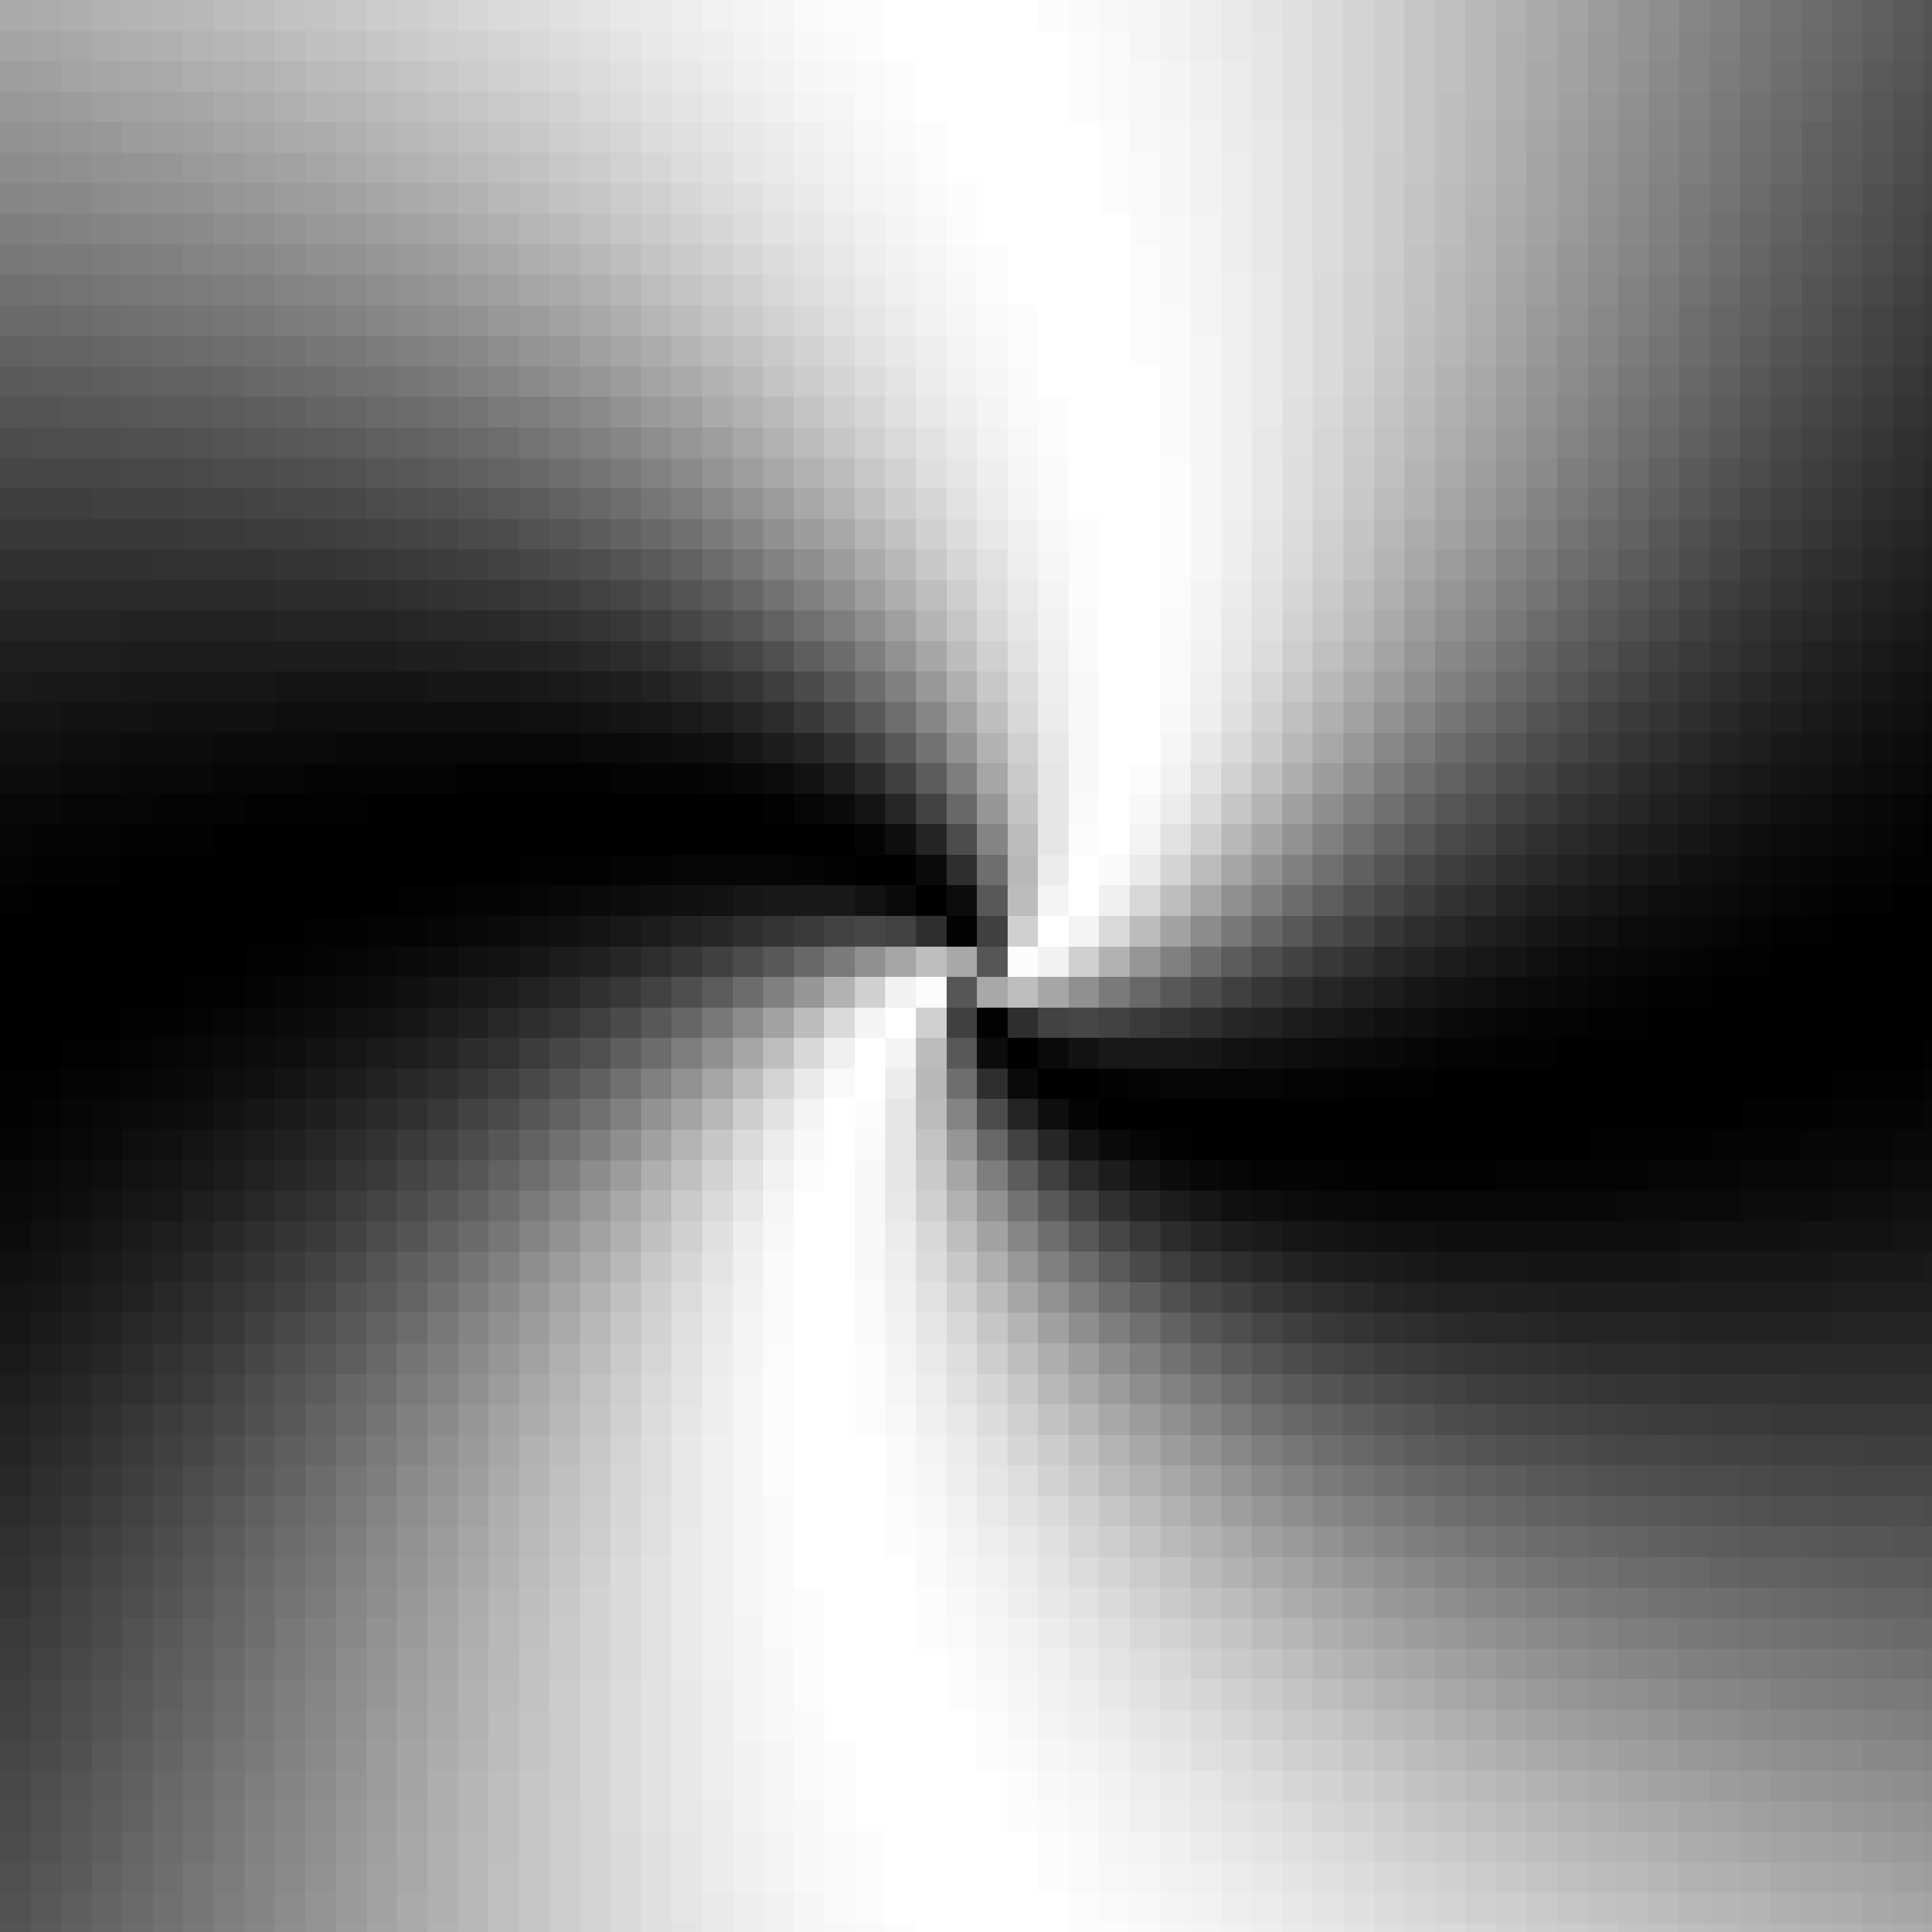
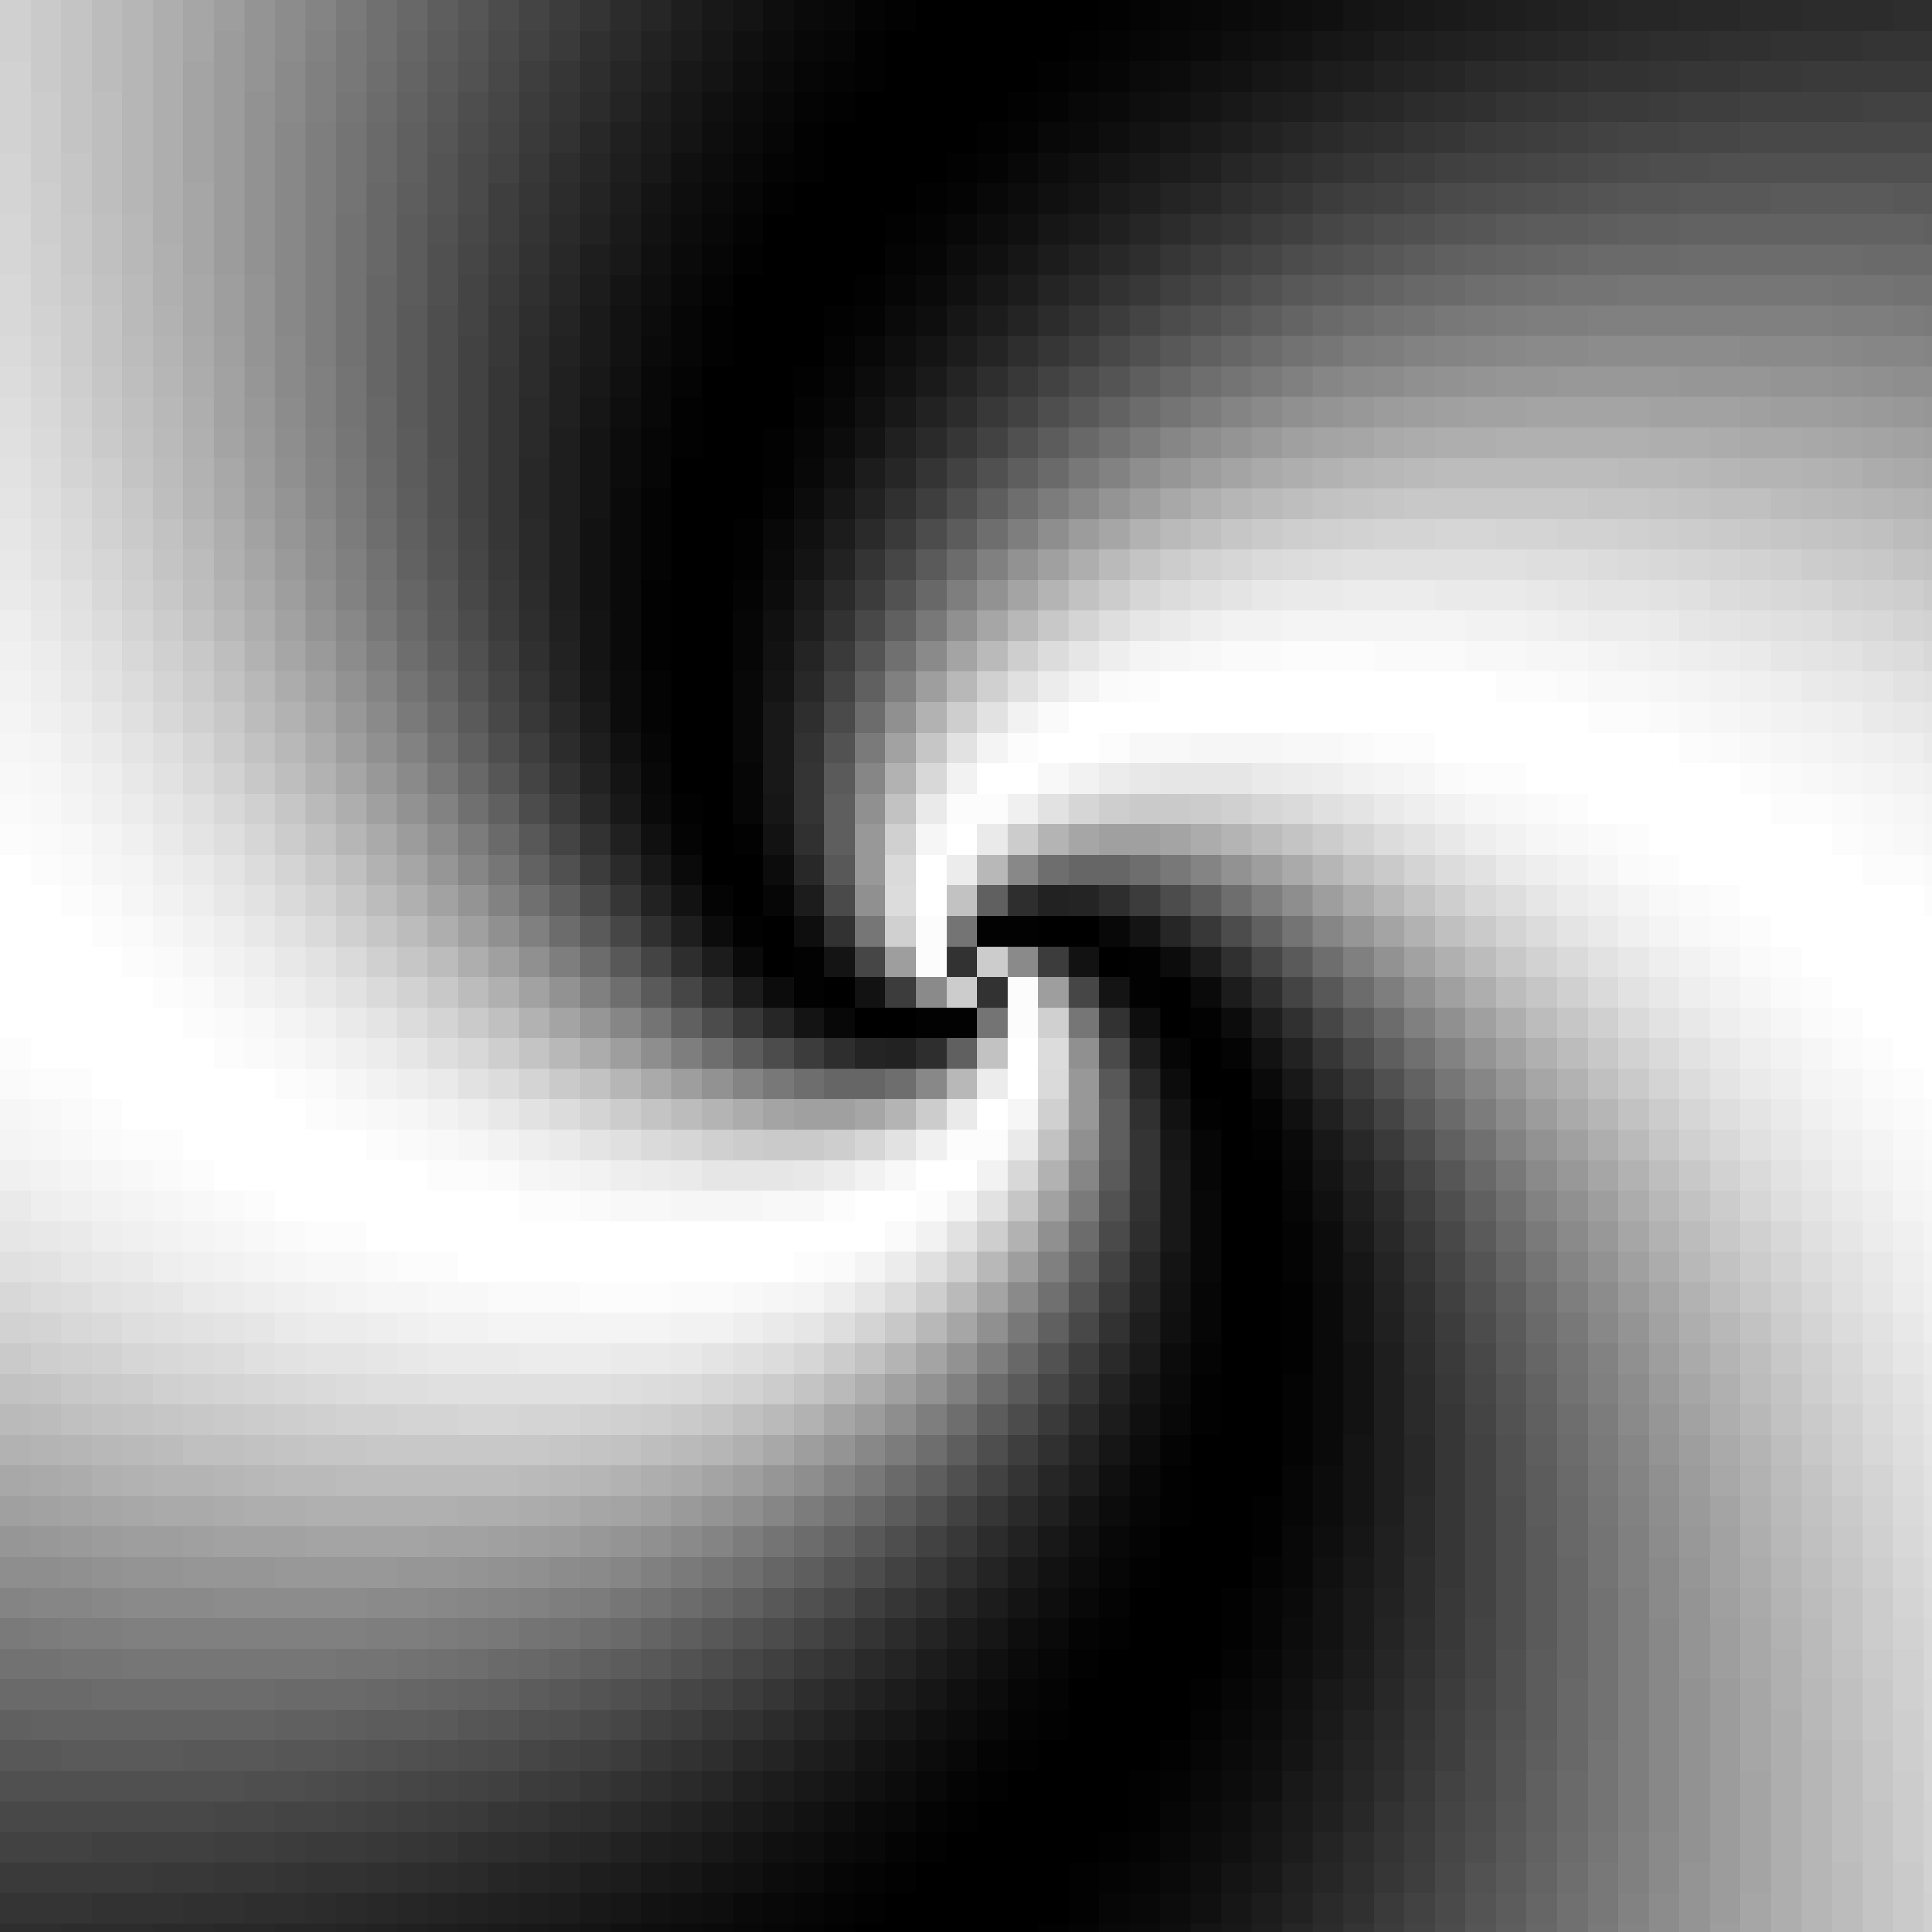
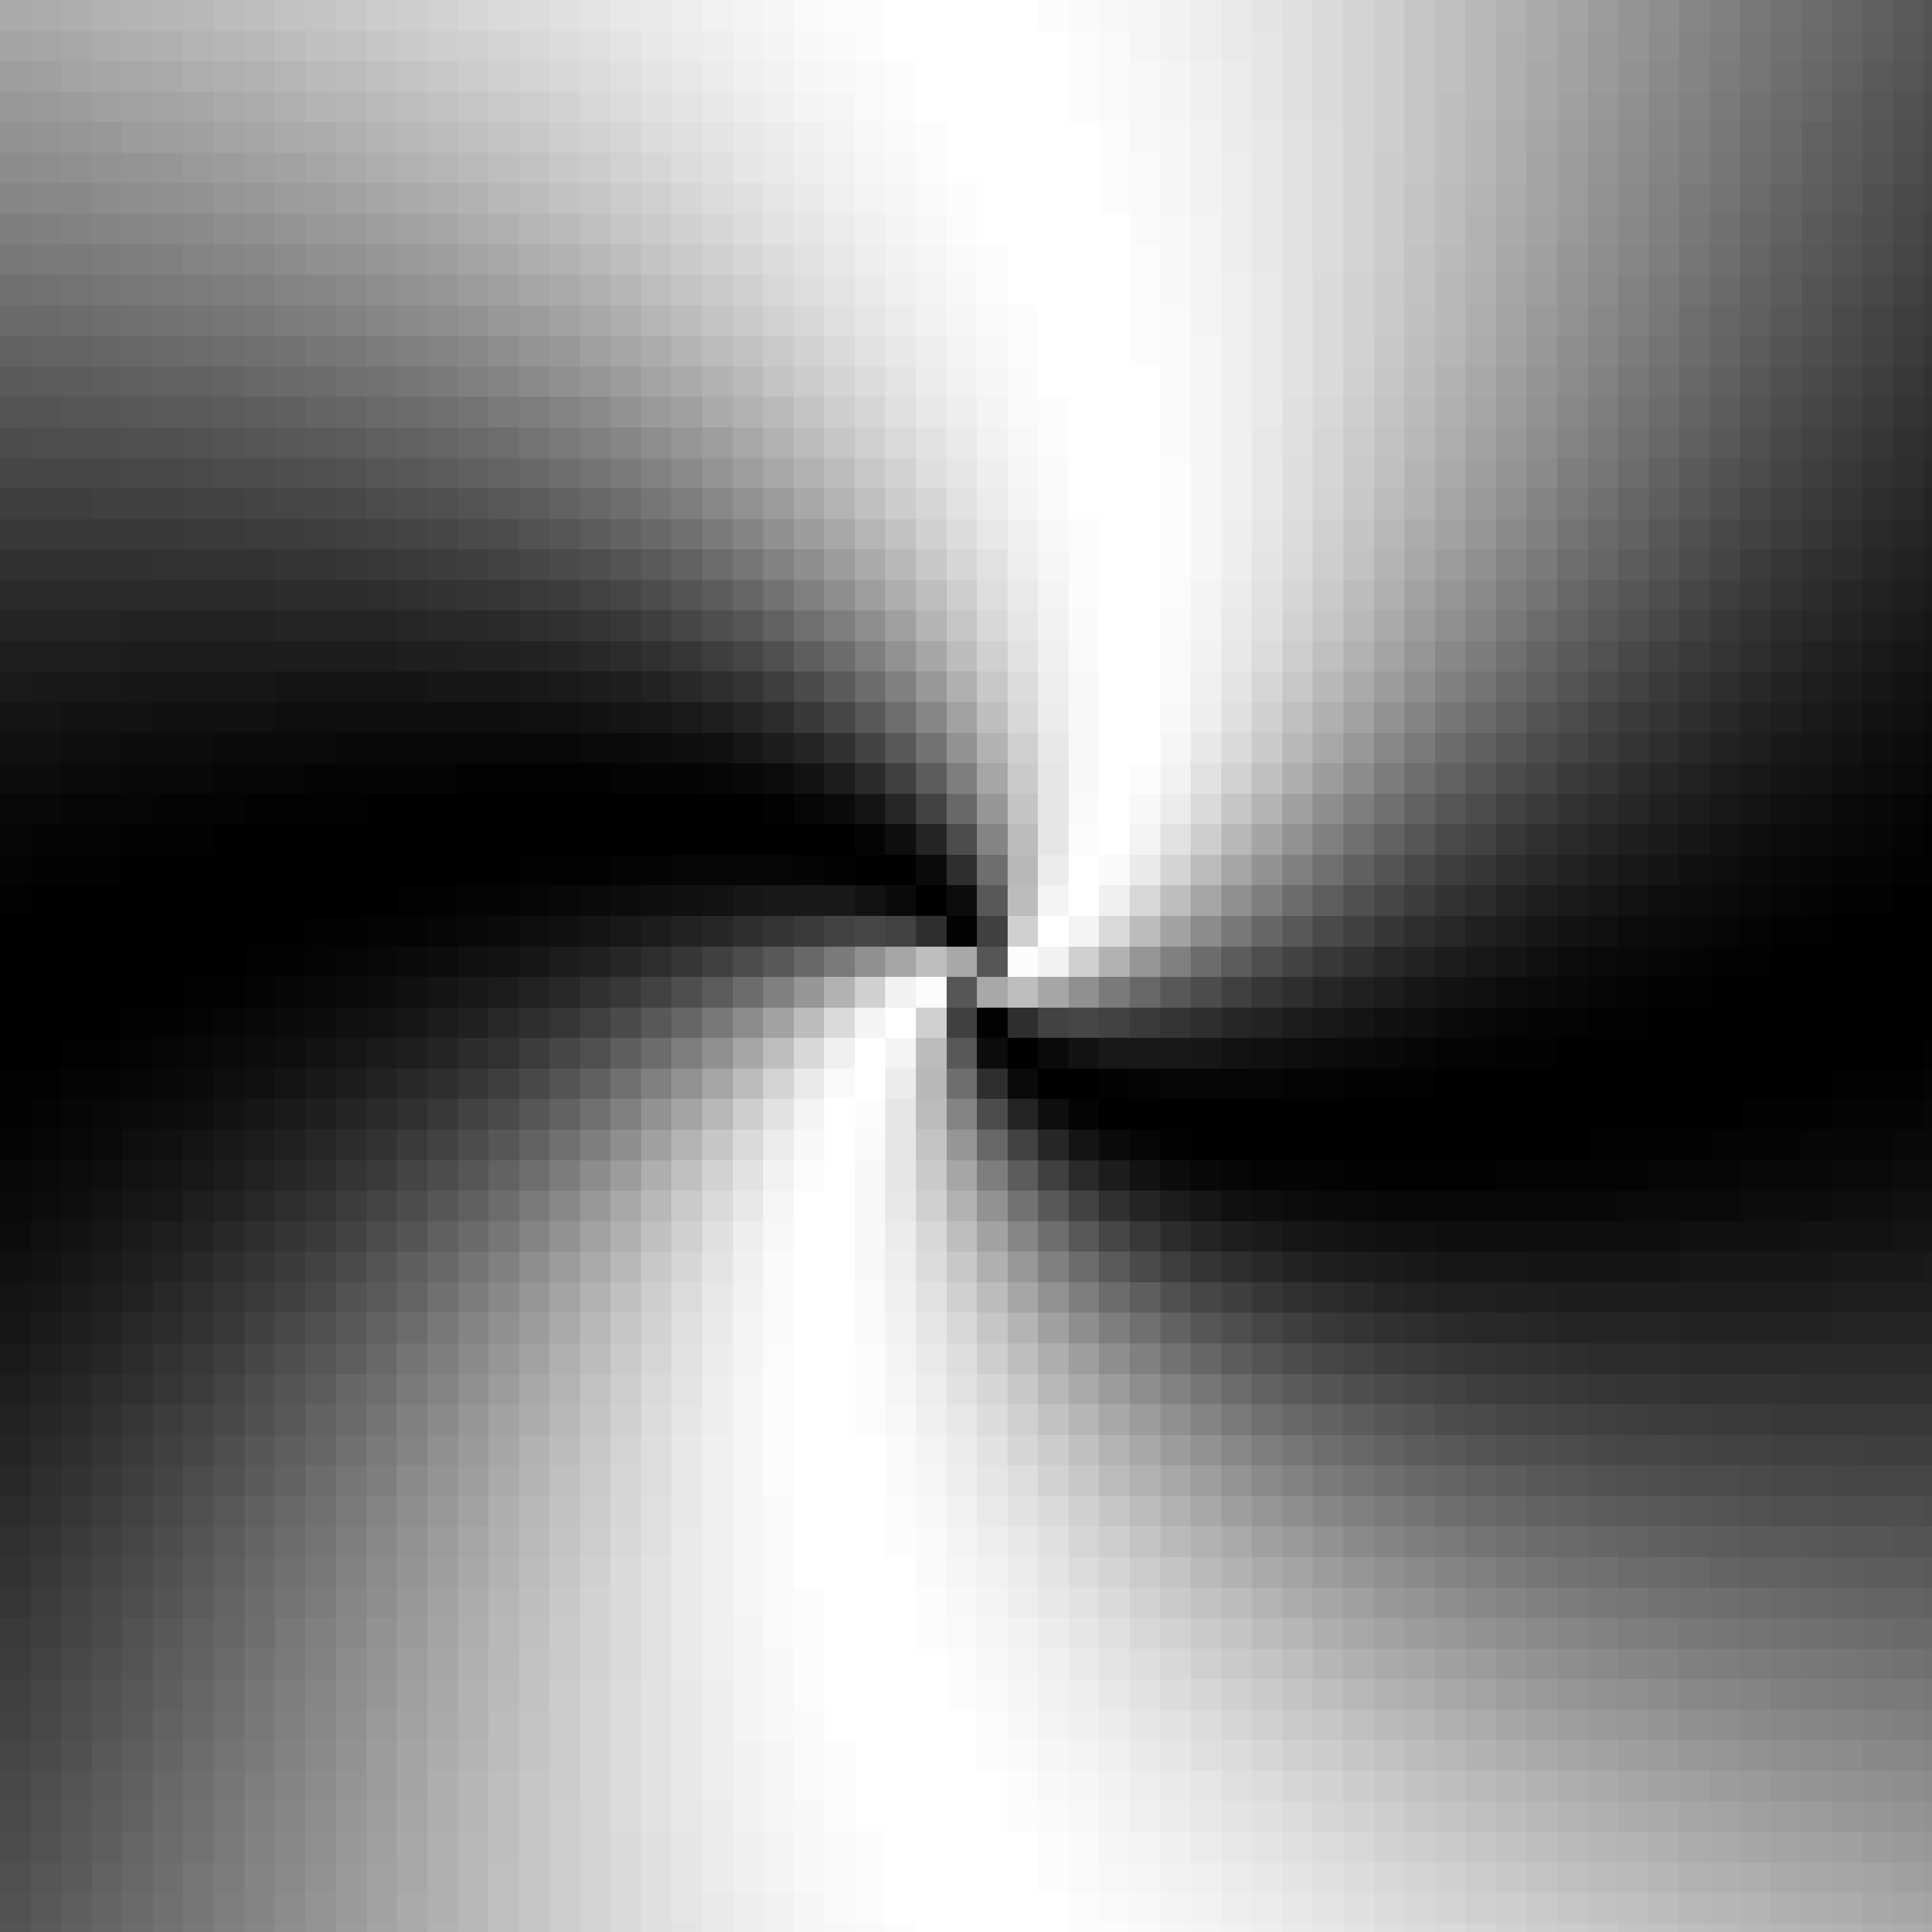
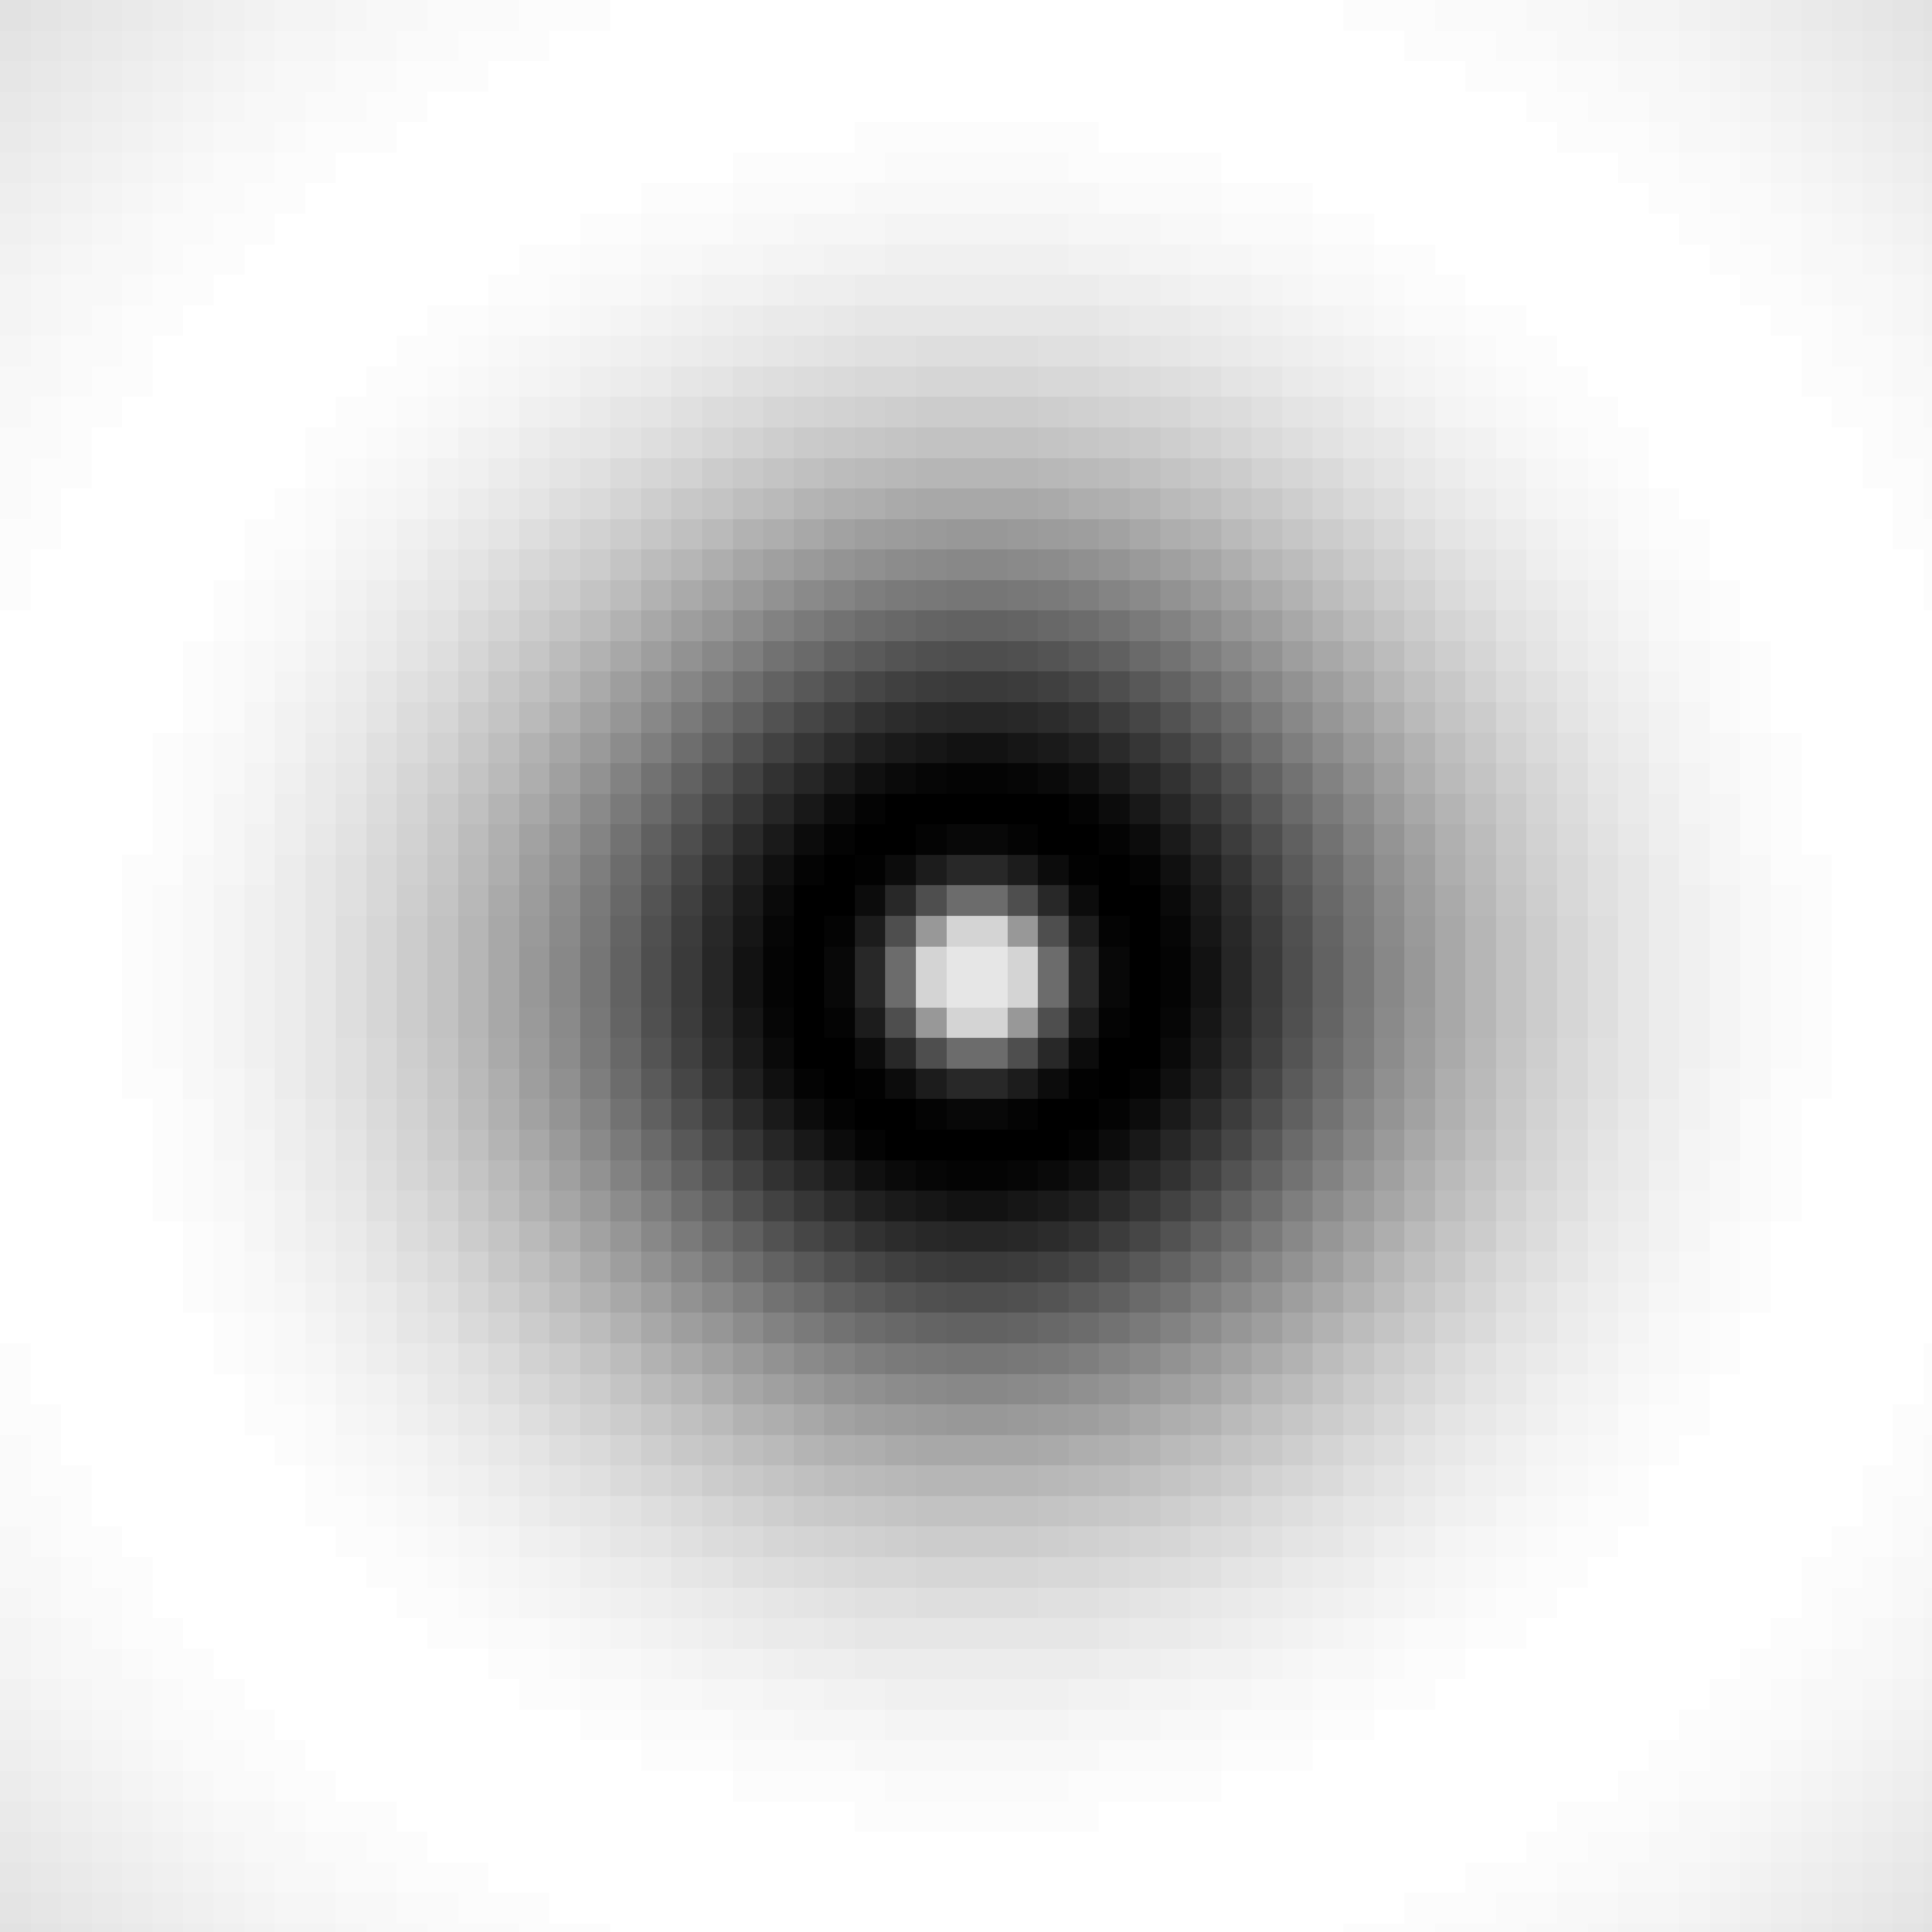
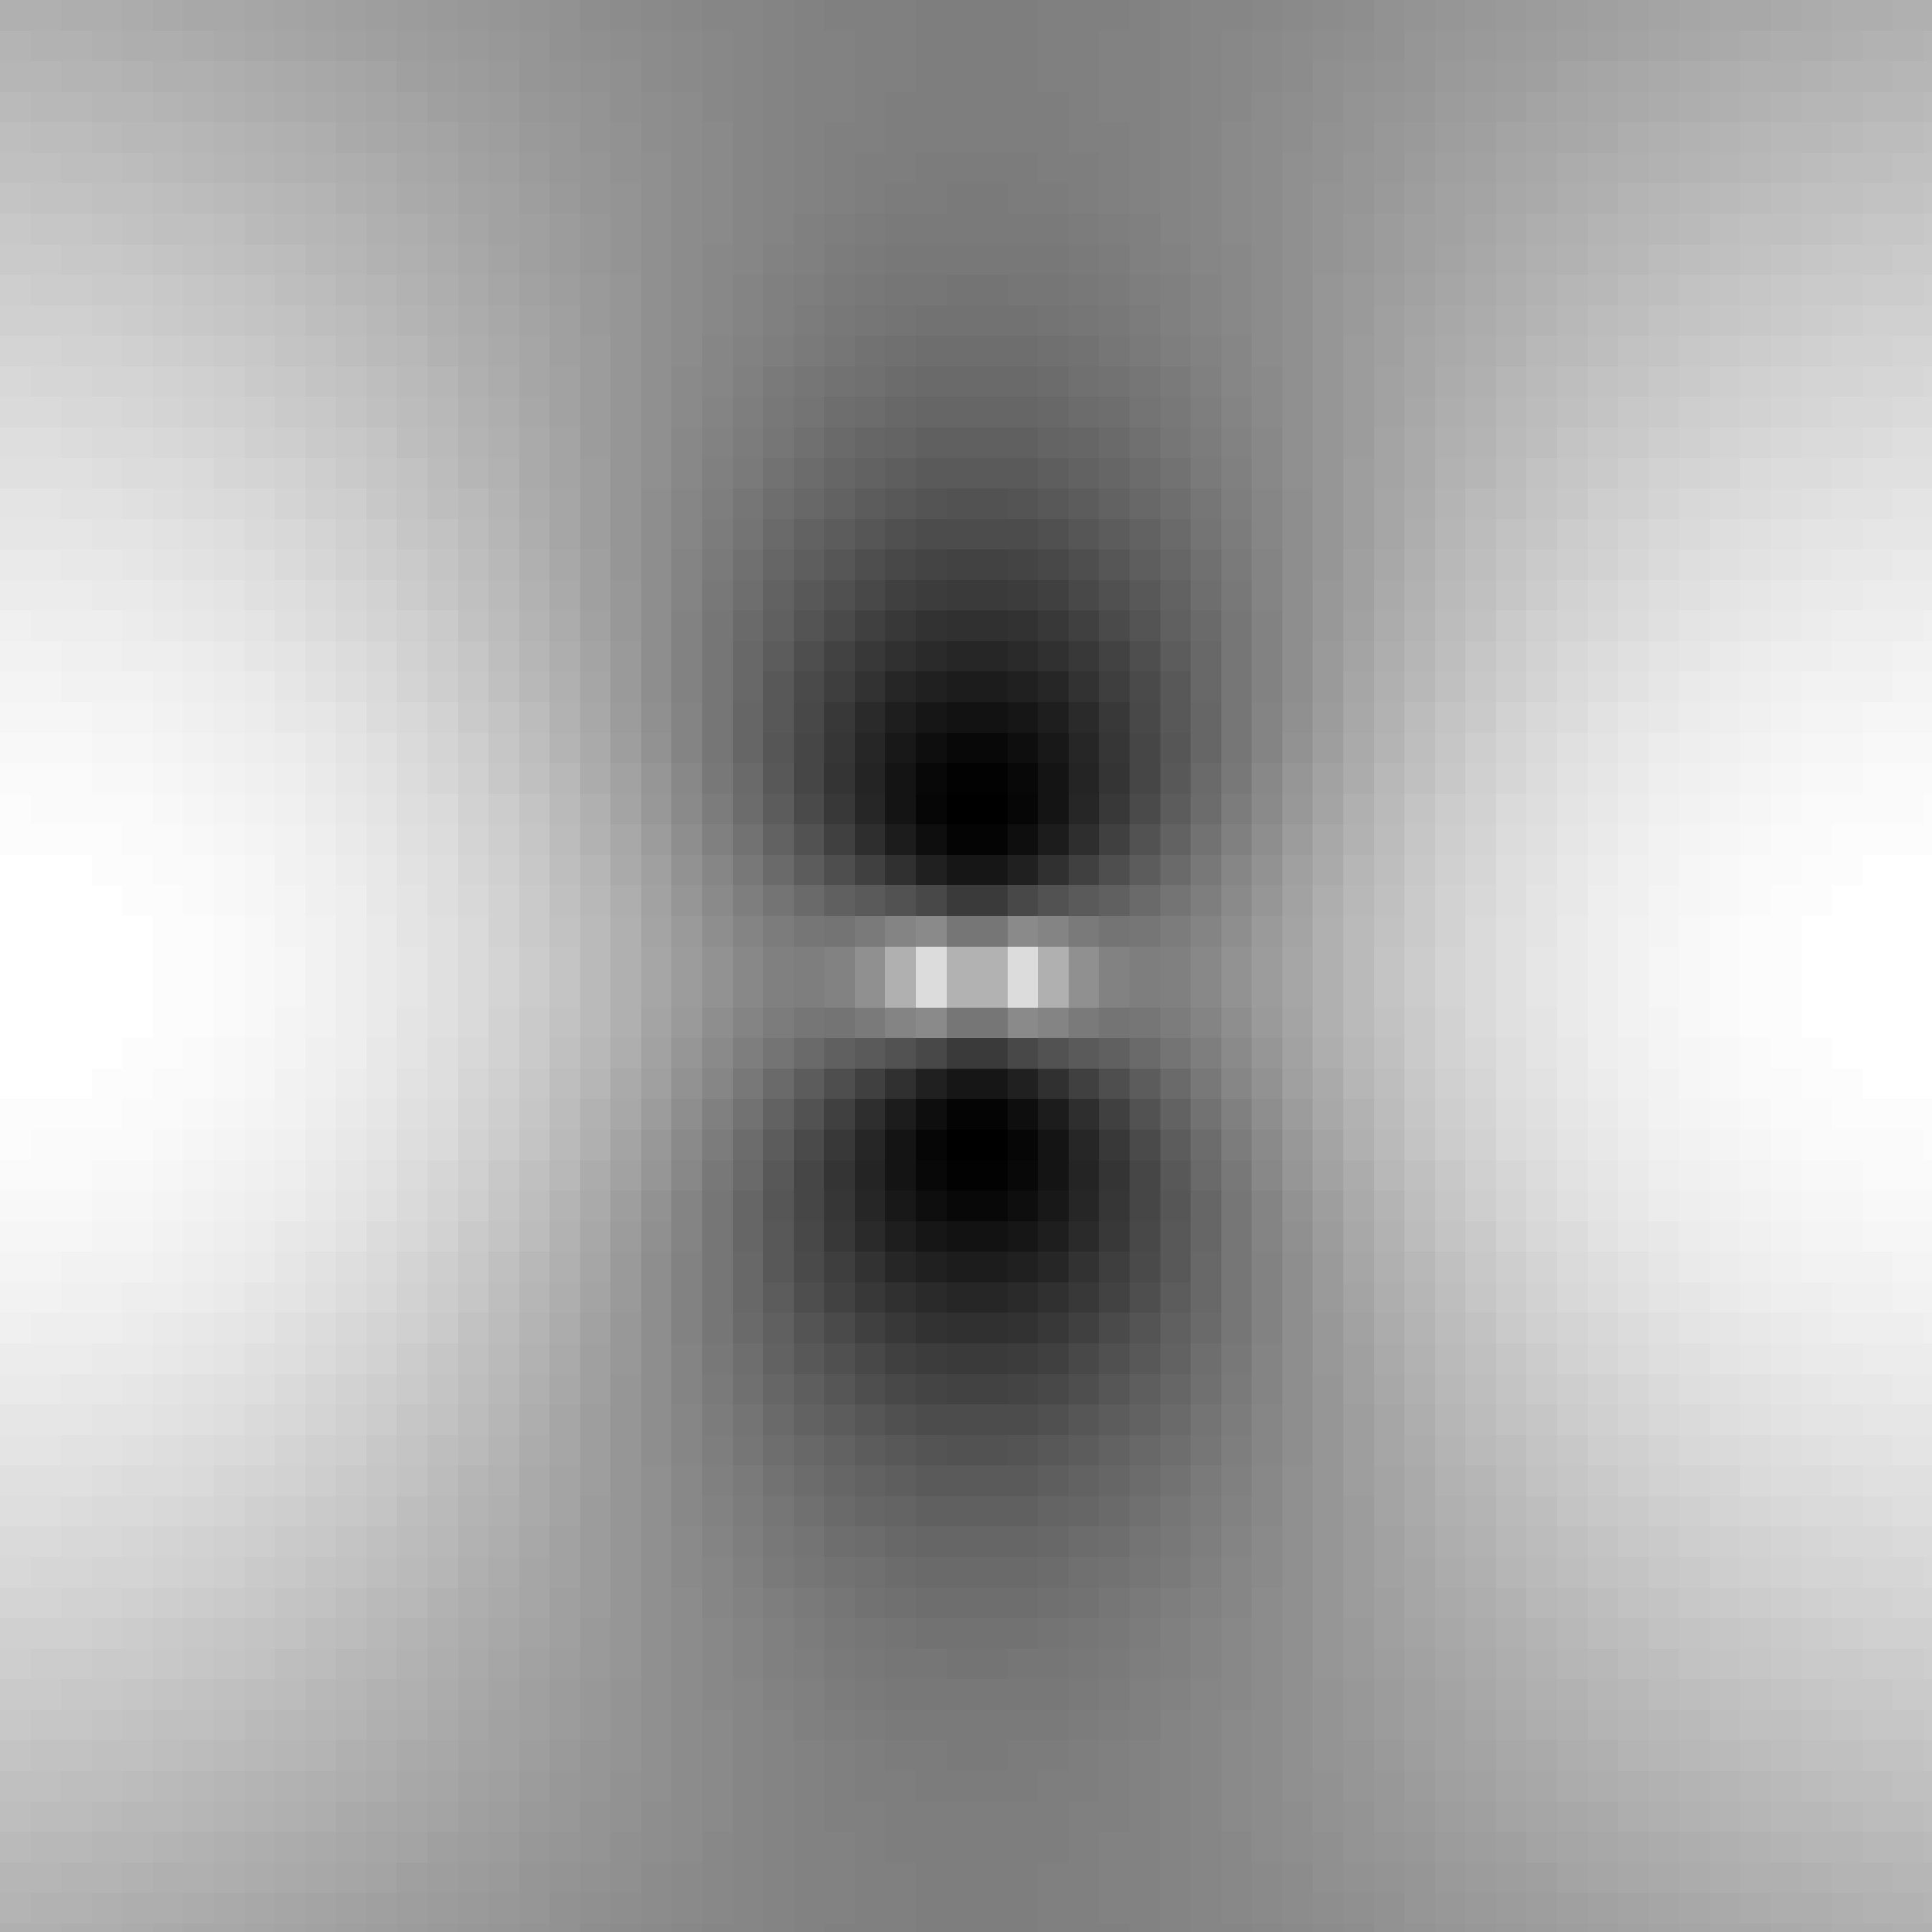

In [3]:
ims = []
freq=2
phase = 0
ampl=1
shape=64
alpha=0
origin = None
ims.append(sfp.stimuli.log_polar_grating(shape, alpha, freq,phi=phase,ampl=ampl, origin=origin))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha, w_a=freq,phi=phase,ampl=ampl))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha, freq/2,freq,phi=phase,ampl=ampl))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha,-freq,freq,phi=phase,ampl=ampl))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha,freq/2,freq,phi=phase,ampl=ampl))
ims.append(sfp.stimuli.log_polar_grating(shape,alpha,freq,freq/4,phi=phase,ampl=ampl))
ims.append(ims[0]+ims[1])
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, alpha, freq, phi=phase, ampl=ampl, orig_origin=origin, check_scale_factor=3))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, alpha, w_a=freq, phi=phase, ampl=ampl, orig_origin=origin, check_scale_factor=3))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, alpha, freq, phi=phase, ampl=ampl, check_scale_factor=50, orig_origin=origin))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, alpha, freq, phi=phase, ampl=ampl, check_scale_factor=200, orig_origin=origin))

# Example stimuli
jbh.showIm(ims, ncols=min(len(ims), 4),zoom=50)

In order to investigate this a little more, we create compare the second, radial stimulus with a more heavily-sampled version.

The first plot shows the central slice of the 64 x 64 image in green and the central slice of the grating 99 times larger in blue. We clearly see some very high frequency signal that is being missed.

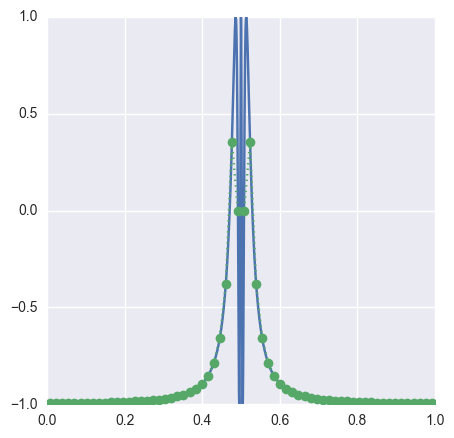

In [4]:
stim, over_sampled_stim = sfp.stimuli.check_aliasing(64, 0, w_a=6)

This second plot shows the two images, and again we can see the aliasing at the center


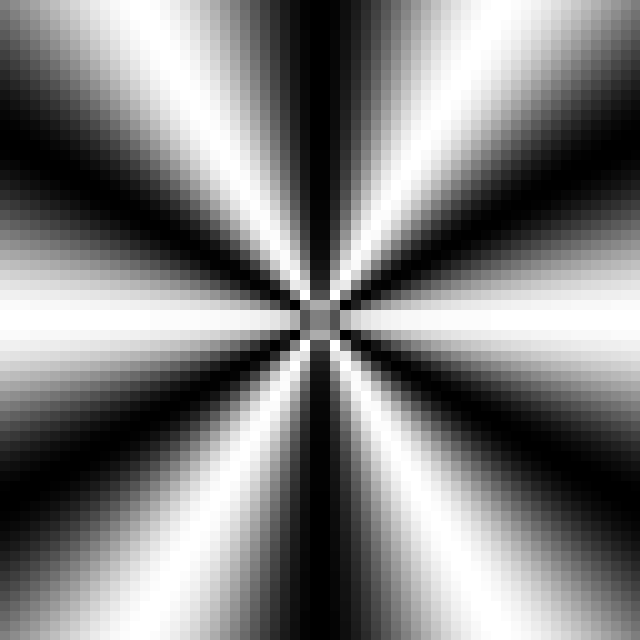
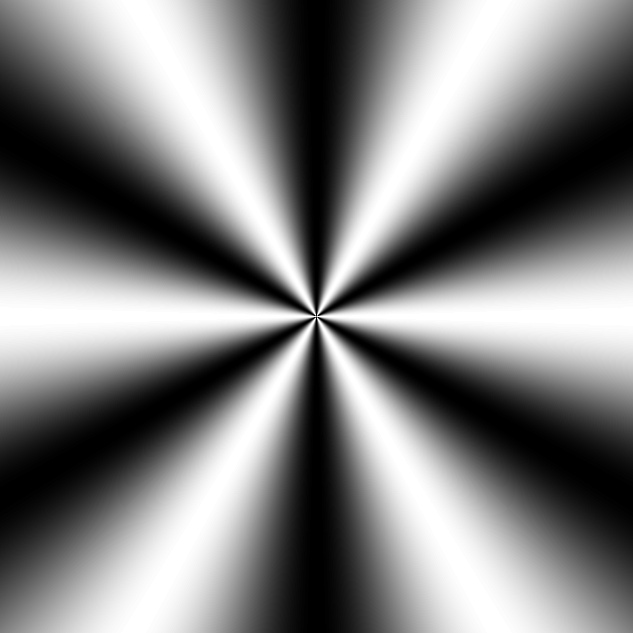

In [5]:
jbh.showIm([stim, over_sampled_stim], ncols=2, zoom=[10, .1])

To deal with this issue, we create a mask that we'll lay at the center of the image, completely masking out the aliased portion of the stimuli and then fading gradually to invisible as we move away from it.

This first plot shows the same slice as above for the un-masked, fade-masked, and binary-masked stimuli.

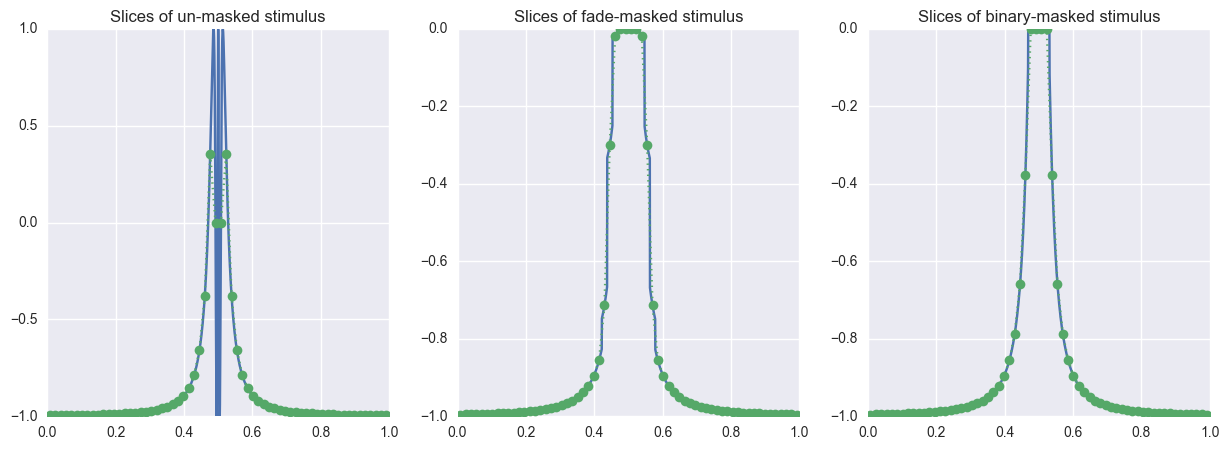

In [6]:
tmps = sfp.stimuli.check_aliasing_with_mask(64, 0, w_a=6, )

This here shows the 64 x 64 image with no mask, the faded mask, and the binary mask. We can see that the masking hides the aliased portion of the image.


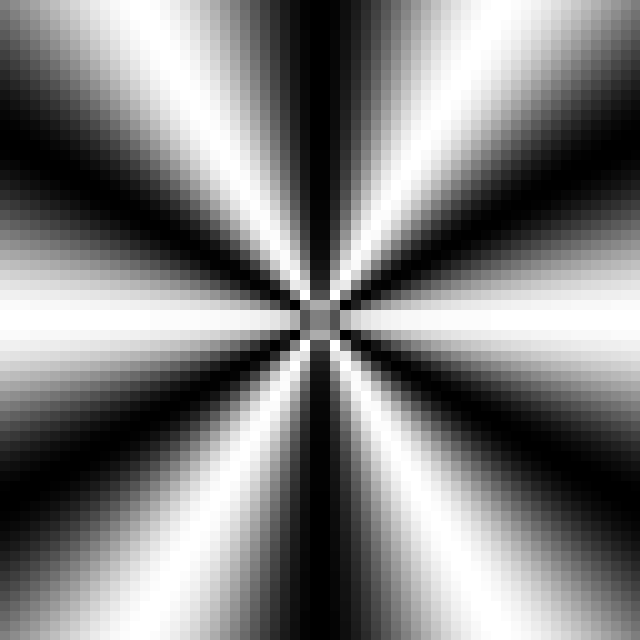
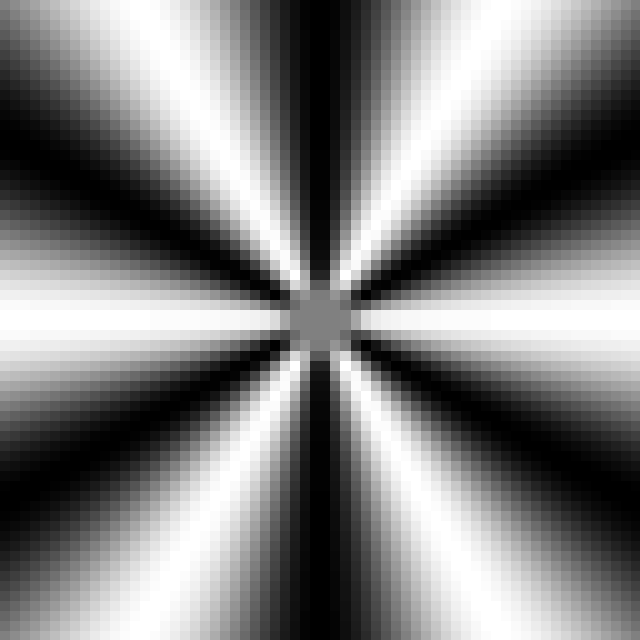
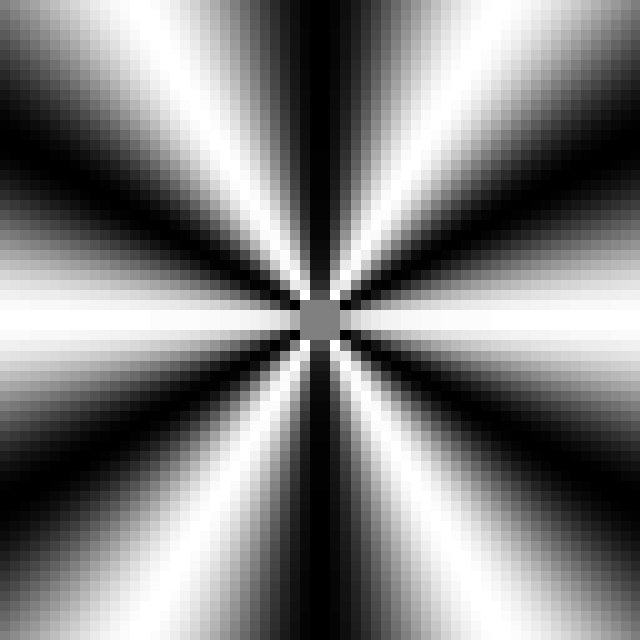

In [7]:
jbh.showIm([tmps[0], tmps[1] * tmps[0], tmps[2] * tmps[0]],# tmps[3], tmps[4]* tmps[3], tmps[5]*tmps[3]], 
           ncols=3, zoom=[10,10,10,.1,.1,.1])

Now that we know the stimuli we want to create and are convinced that masking takes care of their aliasing, we can create the set of stimuli for experiment. We do this using the `gen_stim_set` function, which requires that the `size`, `origin`, `alpha`, and `number_of_fade_pixels` parameters be constant across all stimuli, but allows the others to vary. We create all the stimuli and then apply the largest mask to them, so that all stimuli have the same mask and none show any aliasing. The function returns both the unmasked (`stim`) and masked (`mstim`) versions of the stimuli, but we only want the masked versions (the unmasked are only returned so they can be double-checked).

The following two plots show an example set of (smaller) stimuli and one full-sized one.

To create the exact set of stimuli wanted for the experiment, use the `stimuli.main` function (but note that this can take some time and will save the outputs; it can also be run on the command-line).


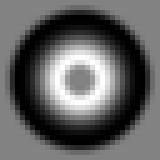
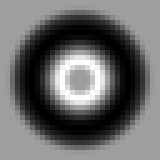
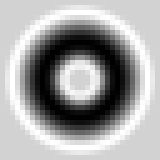
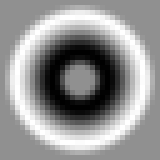
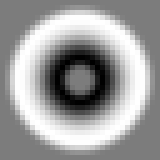
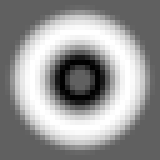
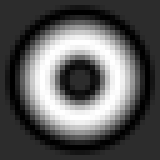
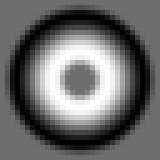
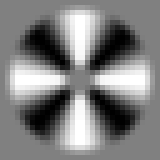
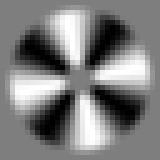
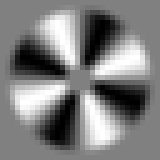
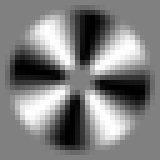
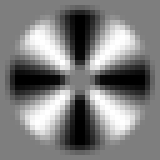
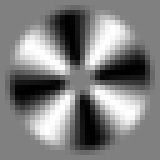
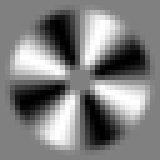
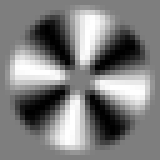
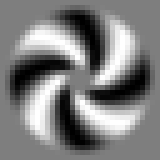
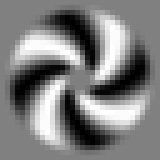
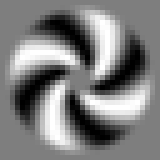
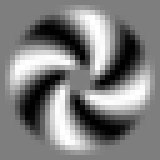
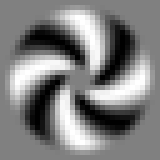
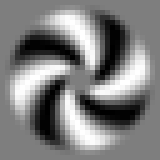
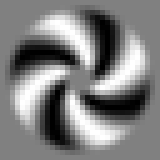
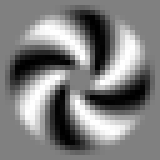

In [8]:
mstim, stim = sfp.stimuli.gen_stim_set(32, 4, freqs_ra=[(4,0),(0,4),(4,4)], phi=np.array(range(8))/8.*2*np.pi, )

#jbh.showIm(stim, ncols=4, zoom=5)
jbh.showIm(mstim, ncols=6, zoom=5)


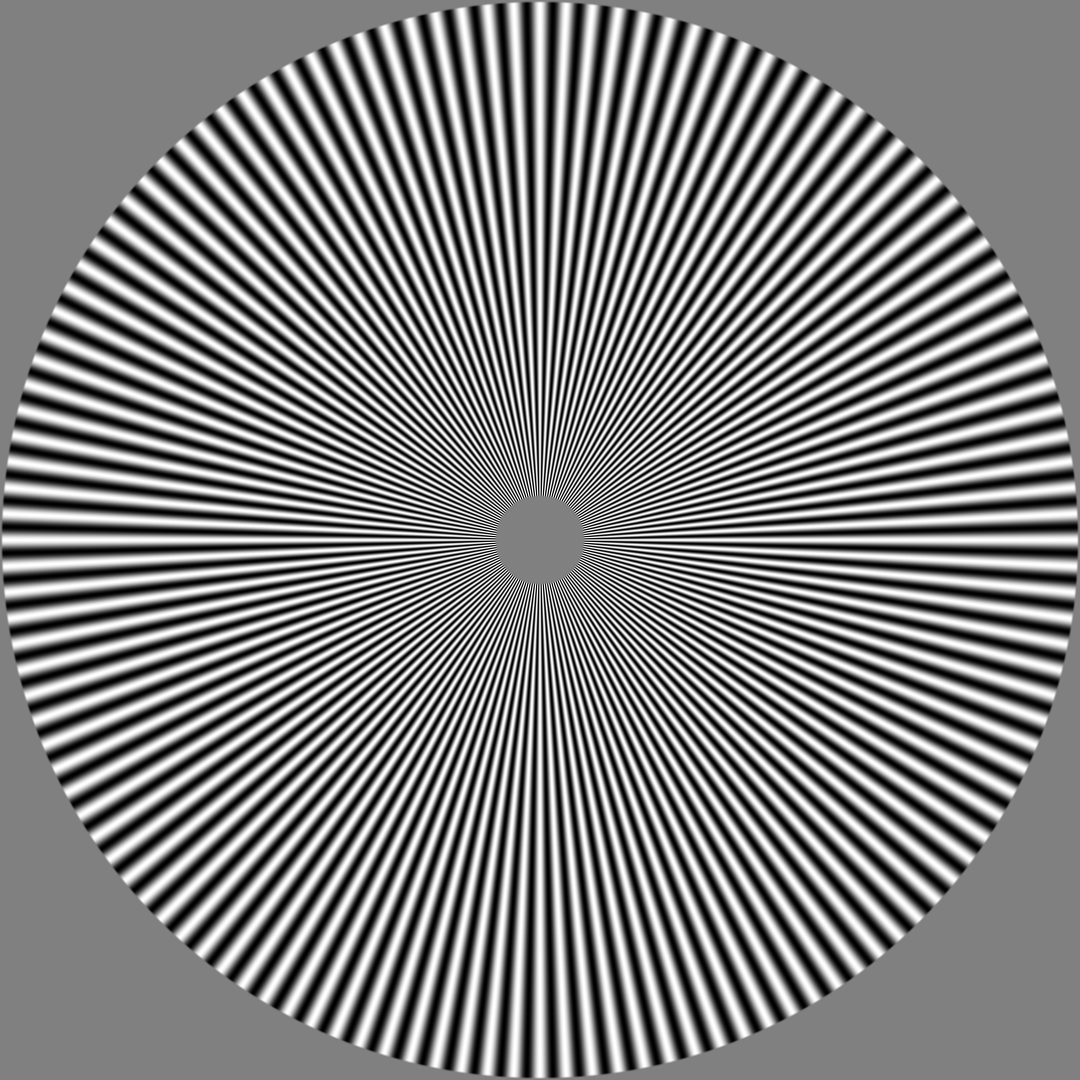

In [9]:
mstim, stim = sfp.stimuli.gen_stim_set(1080, 50, [(0, 128)], bytescale=True)# phi=np.array(range(10))/10.*2*np.pi, )

#jbh.showIm(stim, ncols=4, zoom=5)
jbh.showIm(mstim, ncols=4, )#zoom=5)

# Stimulus properties

For the purposes of creating our stimuli, we're interested in a couple of numbers that aren't apparent from the plots above:

 - how big the anti-aliasing mask in the center will be
 - what the minimum spatial frequency in the stimulus will be
 - what the maximum spatial frequency (after applying the mask) will be

for the spatial frequencies, we're interested in this in units of cycles per visual degree, so we create the full-size stimulus (1080 x 1080 pixels) and input the diameter of the stimulus in visual degrees (28).

In [10]:
mask_df = sfp.stimuli.check_stim_properties(1080, None, 28, w_r=range(0,1100,100), w_a=range(0,1100,100), 
                                            alpha=range(0,500,50))

We see that the mask grows with the frequencies and, as expected, a large alpha means less dependence on $\omega_r$. It gets pretty big.

Note that the mask size is *only* dependent on the frequency content the image, not the size of the image. So if you have $\omega_a=500$, your mask will always be 186 pixels wide, so if your image is only 150 pixels per side, then your entire image will be blank.

/home/billbrod/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


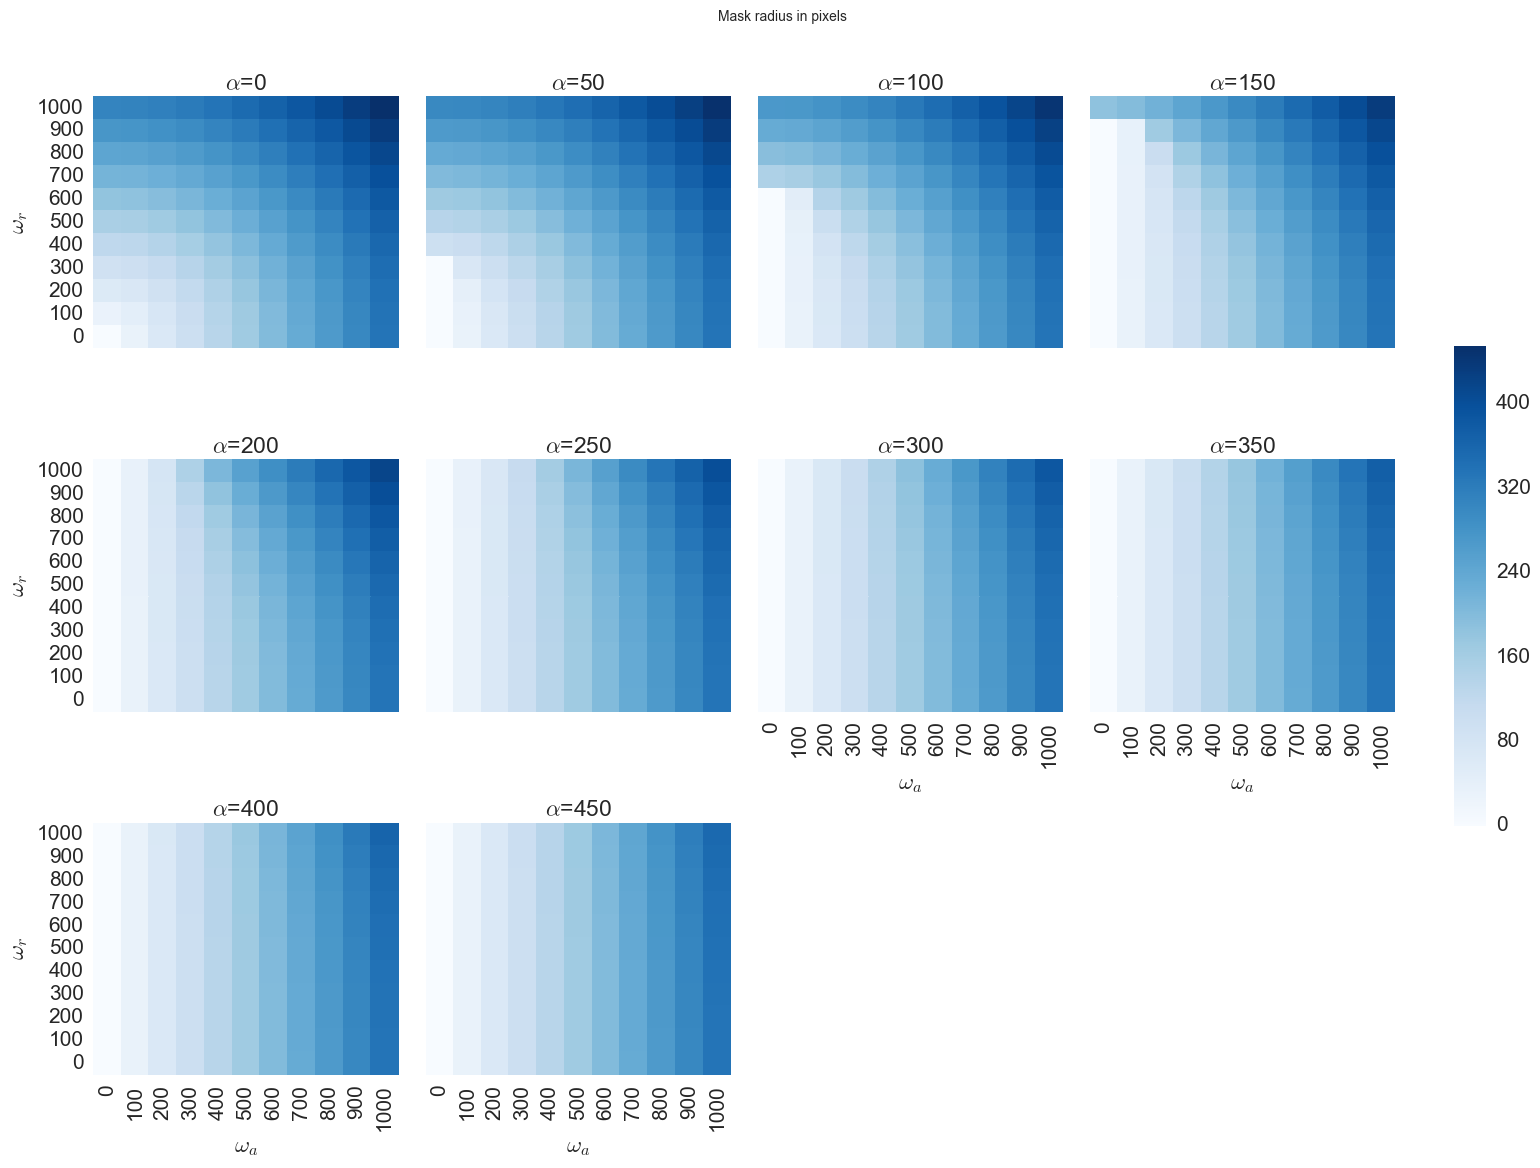

In [11]:
sfp.stimuli.plot_stim_properties(mask_df, size=4)

This next plot isn't as interesting, but it's a sanity check to make sure the mask is working: basically, we want to see that the mask is working and so nowhere do we get frequencies exceeding .5 cycles per pixel. This shows that that's the case: no matter how high the frequencies go in either direction, they always stay below .5

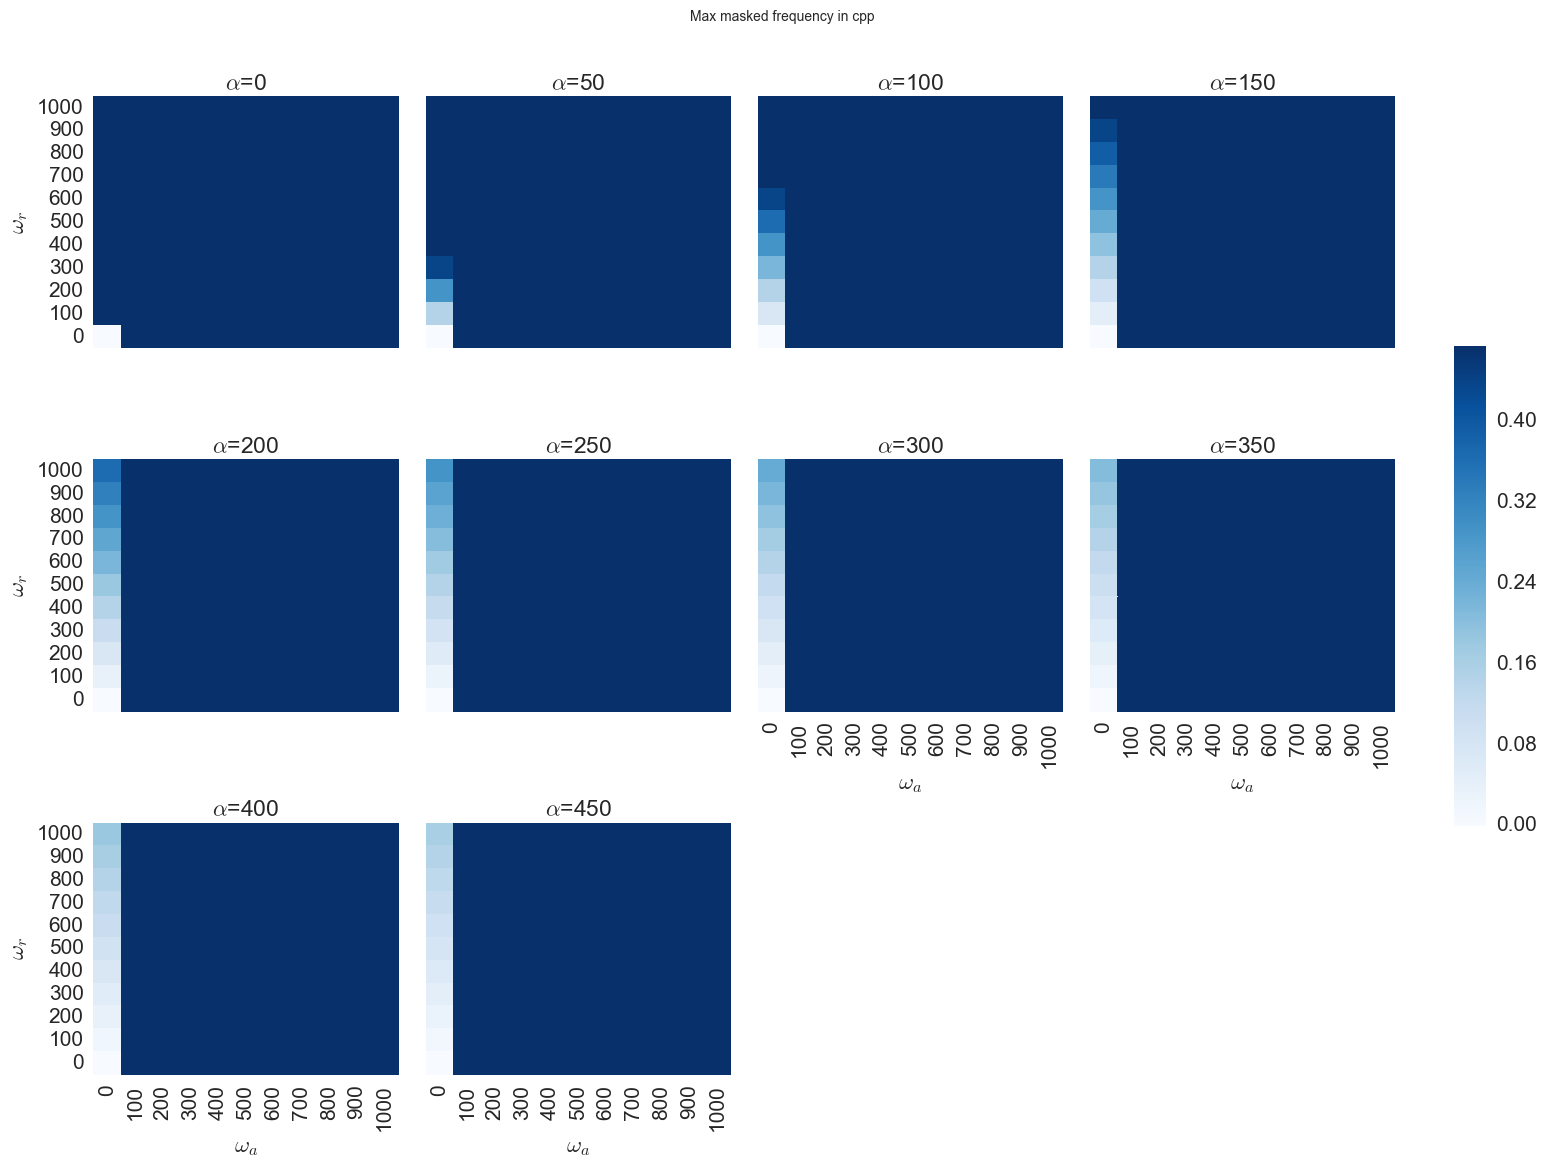

In [13]:
sfp.stimuli.plot_stim_properties(mask_df, data_label='cpp_masked_max', title_text="Max masked frequency in cpp", size=4)

# Experiment stimuli

Your stimuli should be created from the command line (in the `spatial_frequency_preferences` directory, call `python -m sfp.stimuli -h` to view the helpstring), but this here loads in the unshuffled stimuli and descriptive dataframe and examines some of them.

In [14]:
stim = np.load("../data/test/unshuffled.npy")
df = pd.read_csv("../data/test/unshuffled_stim_description.csv", index_col=0)


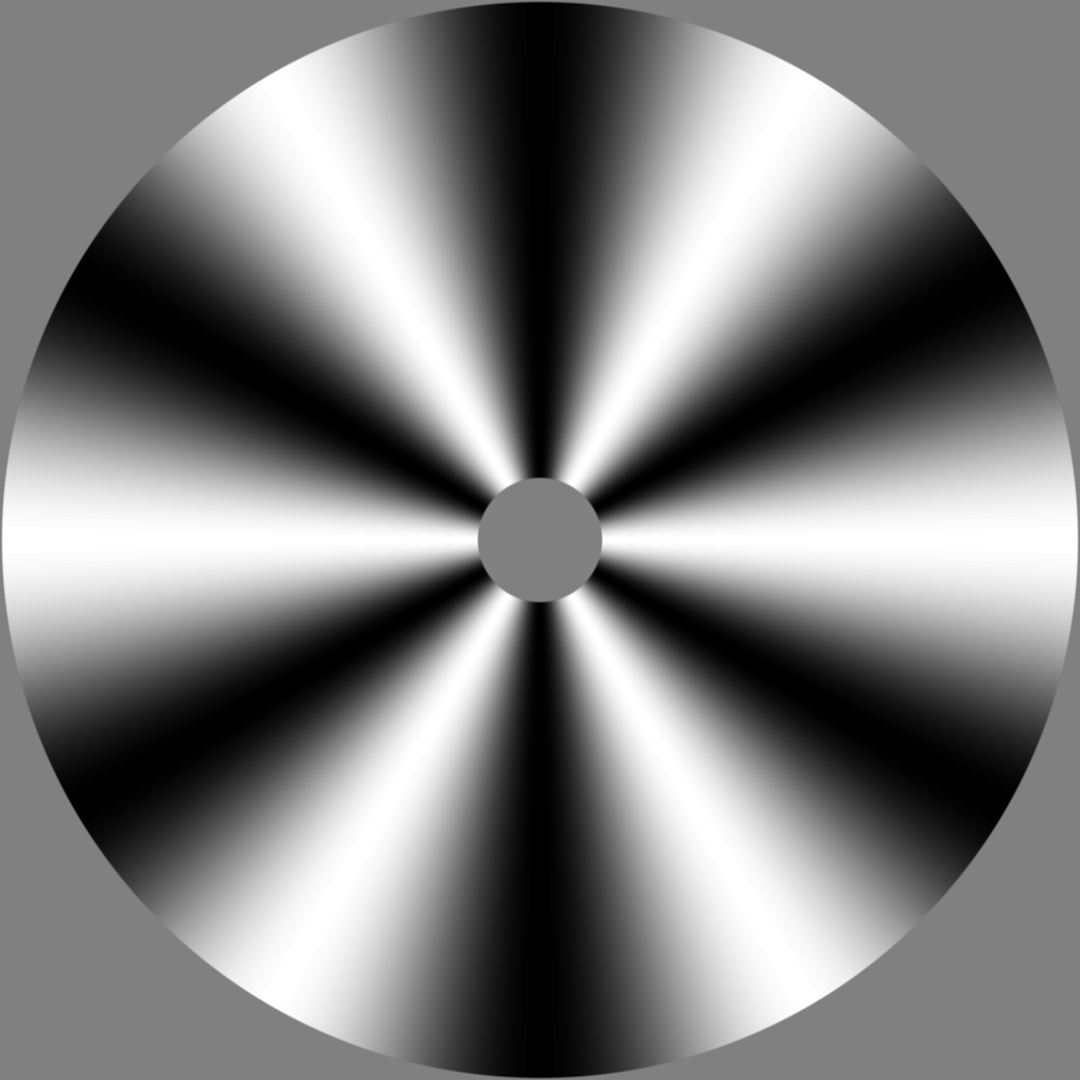
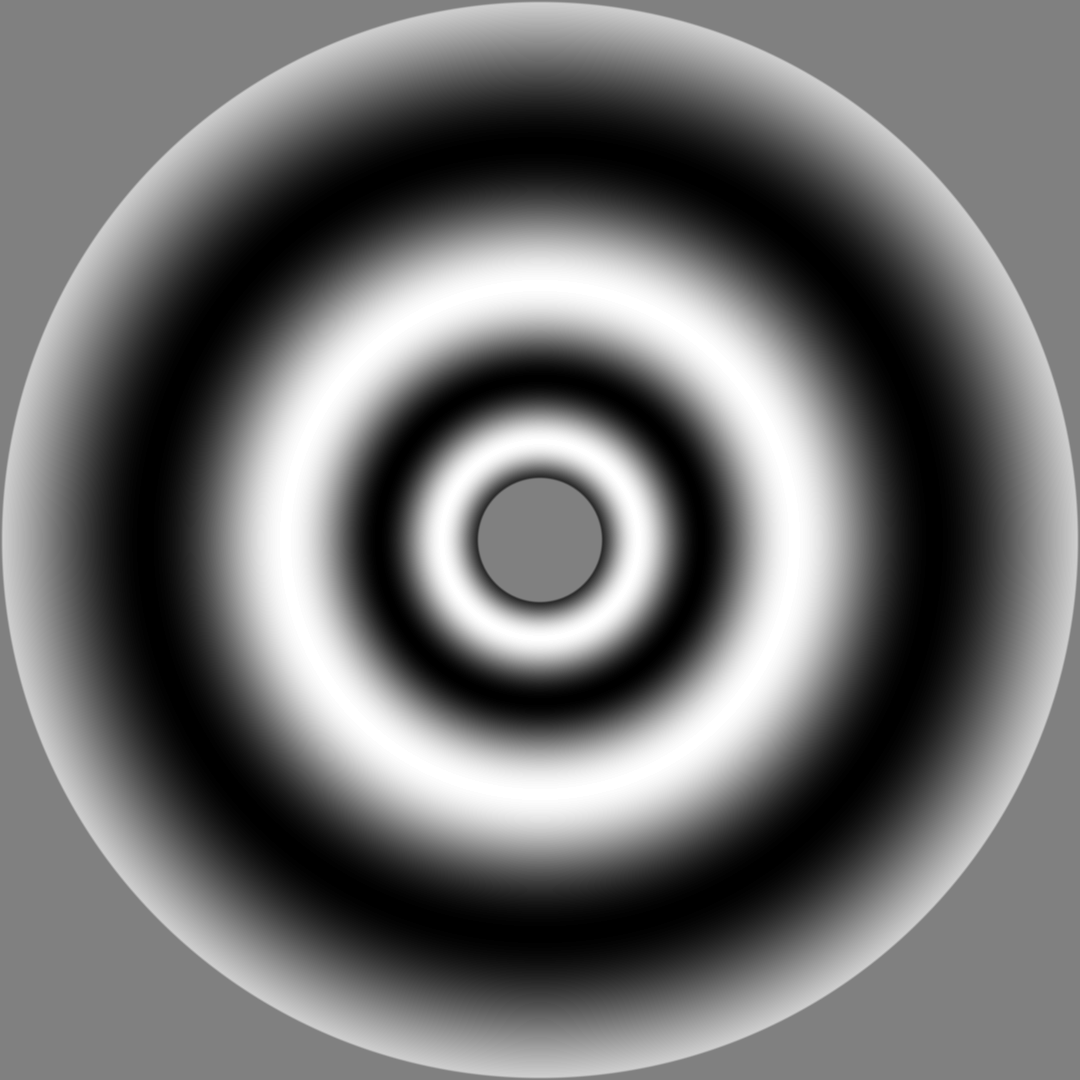
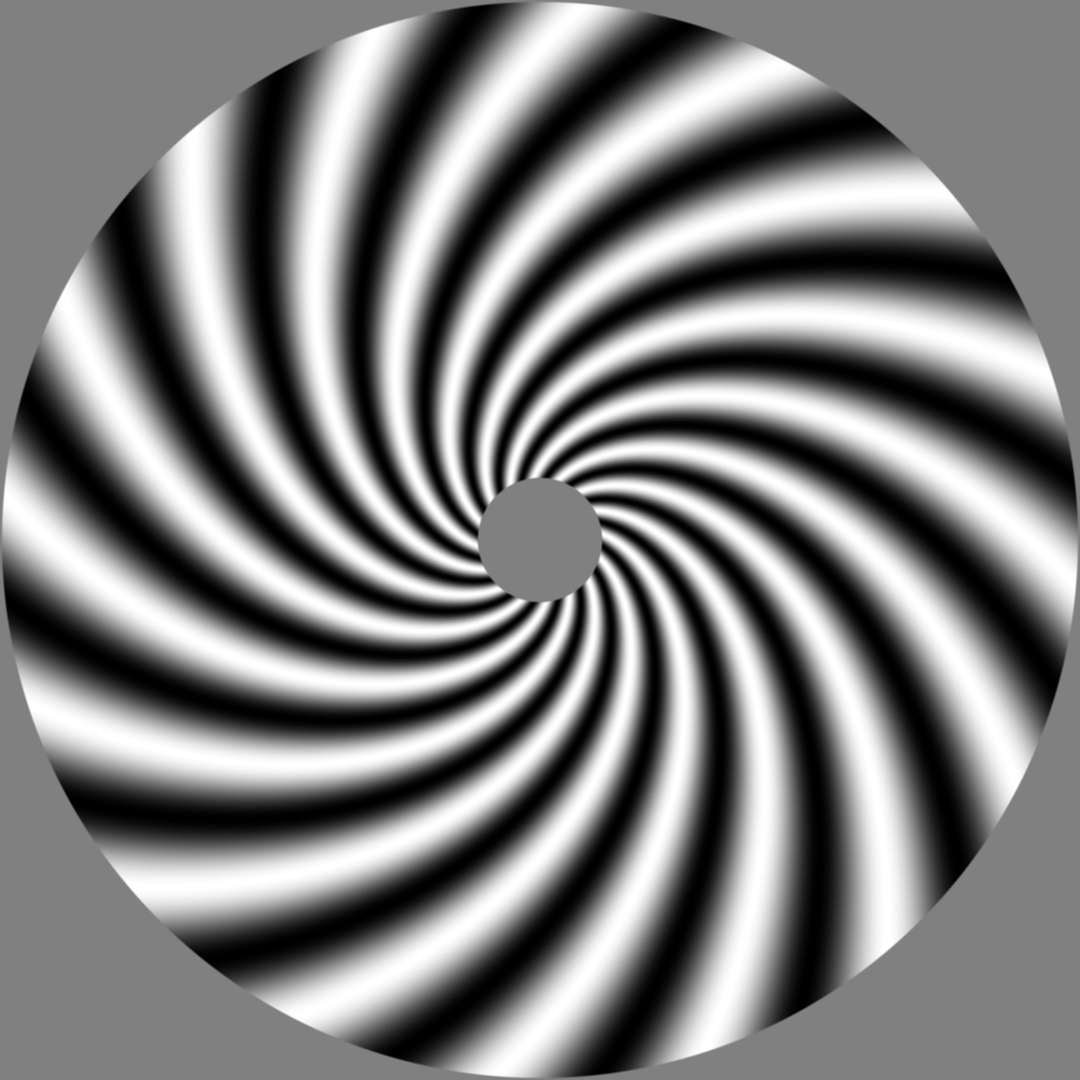

In [15]:
ax = jbh.showIm([stim[0], stim[100], stim[300]], ncols=3)


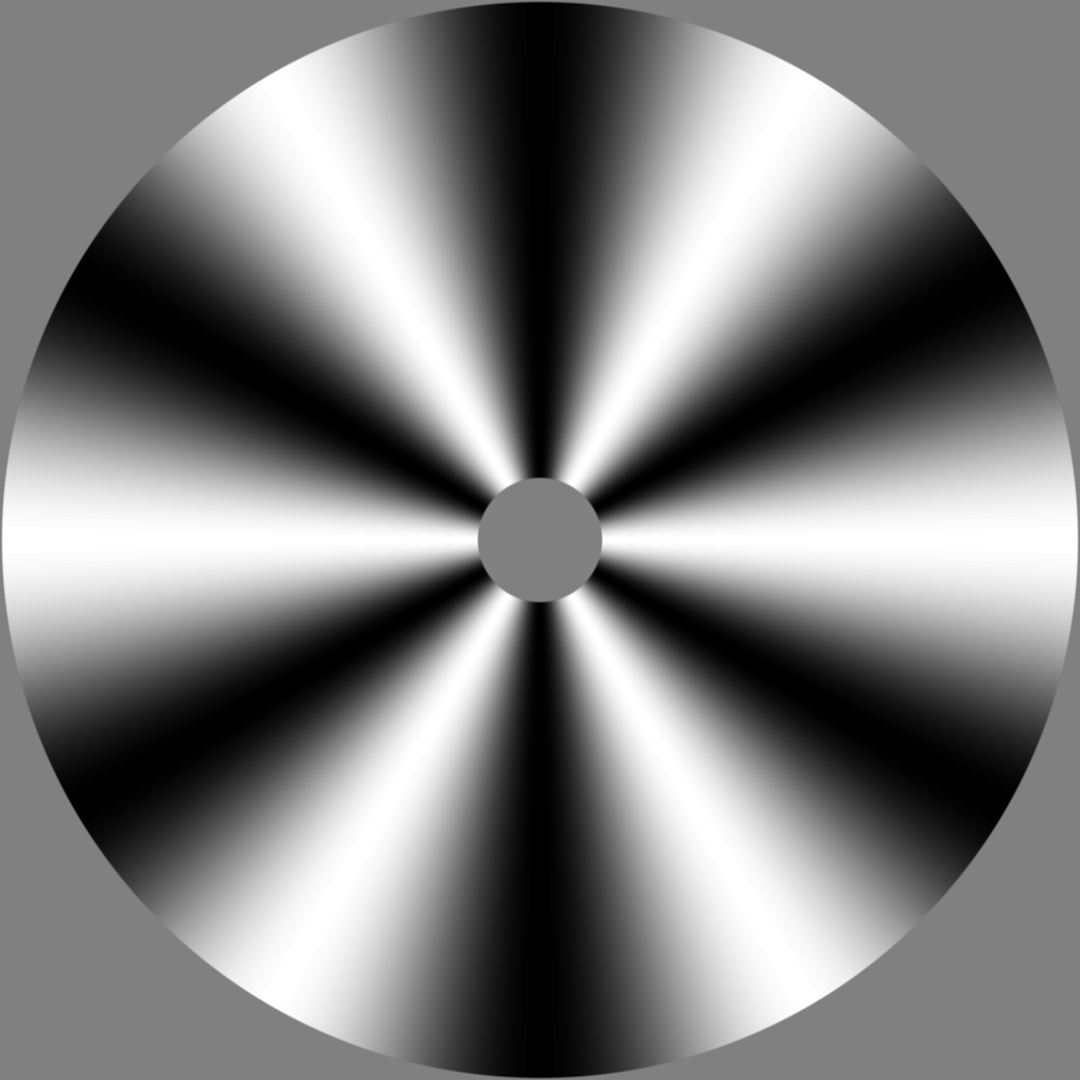
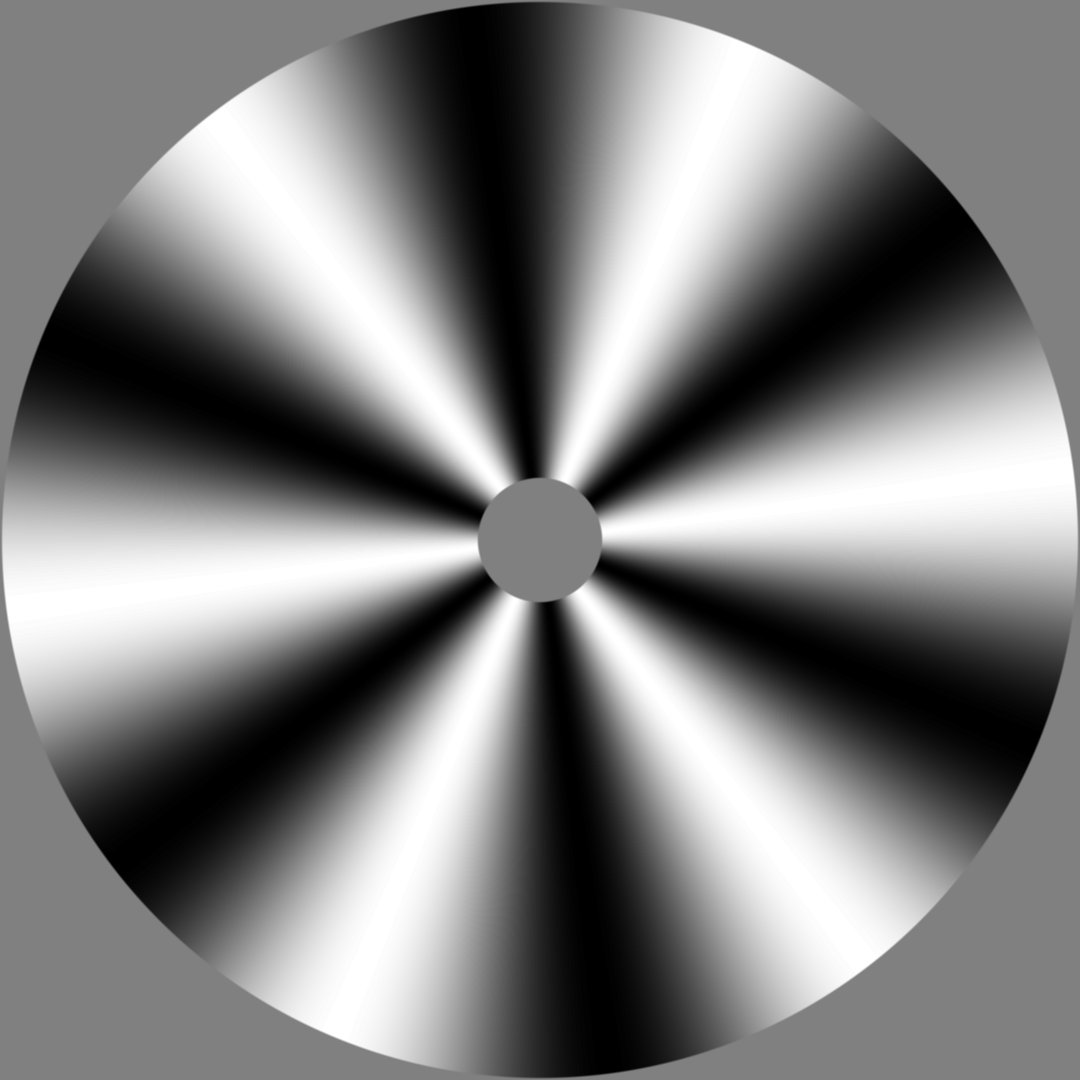
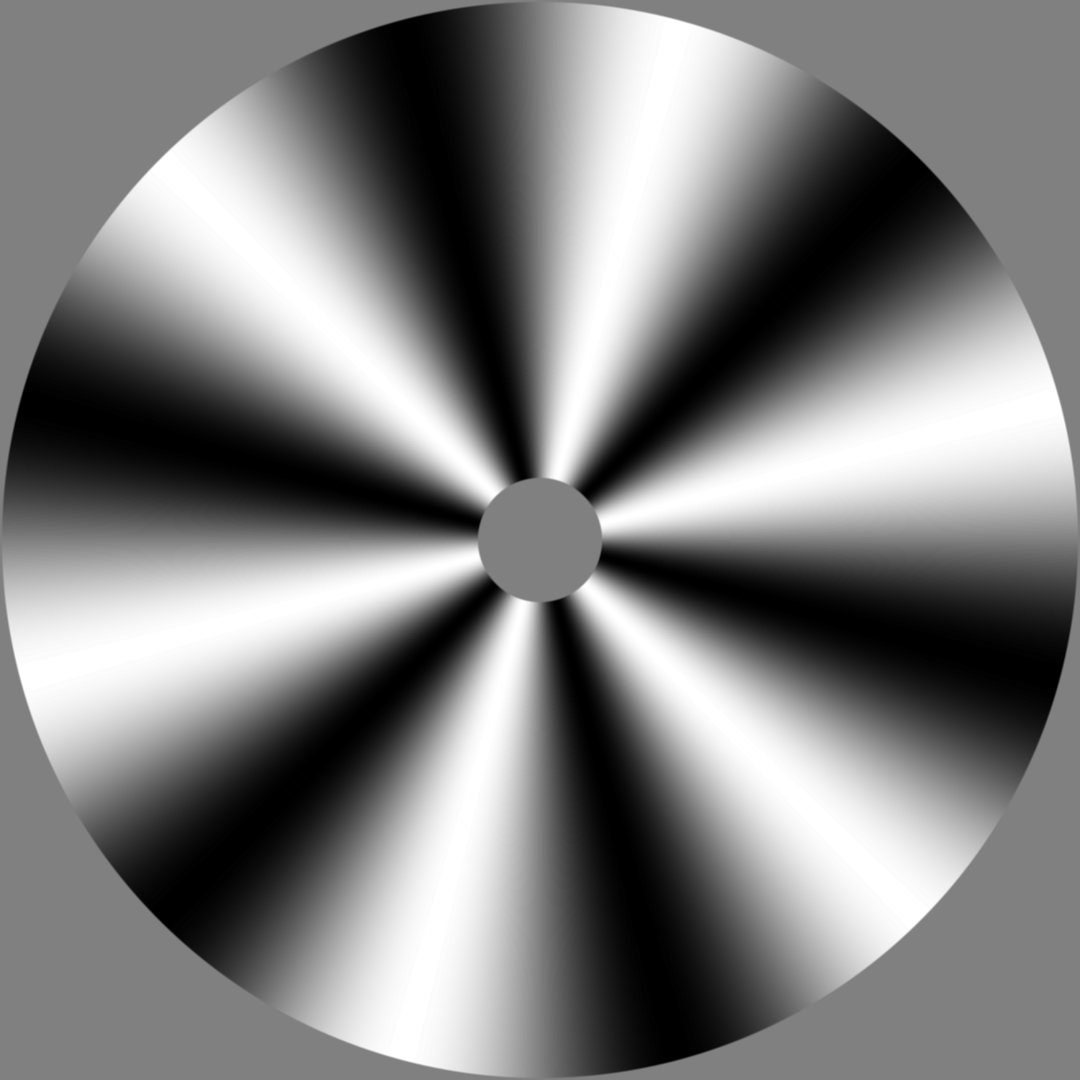
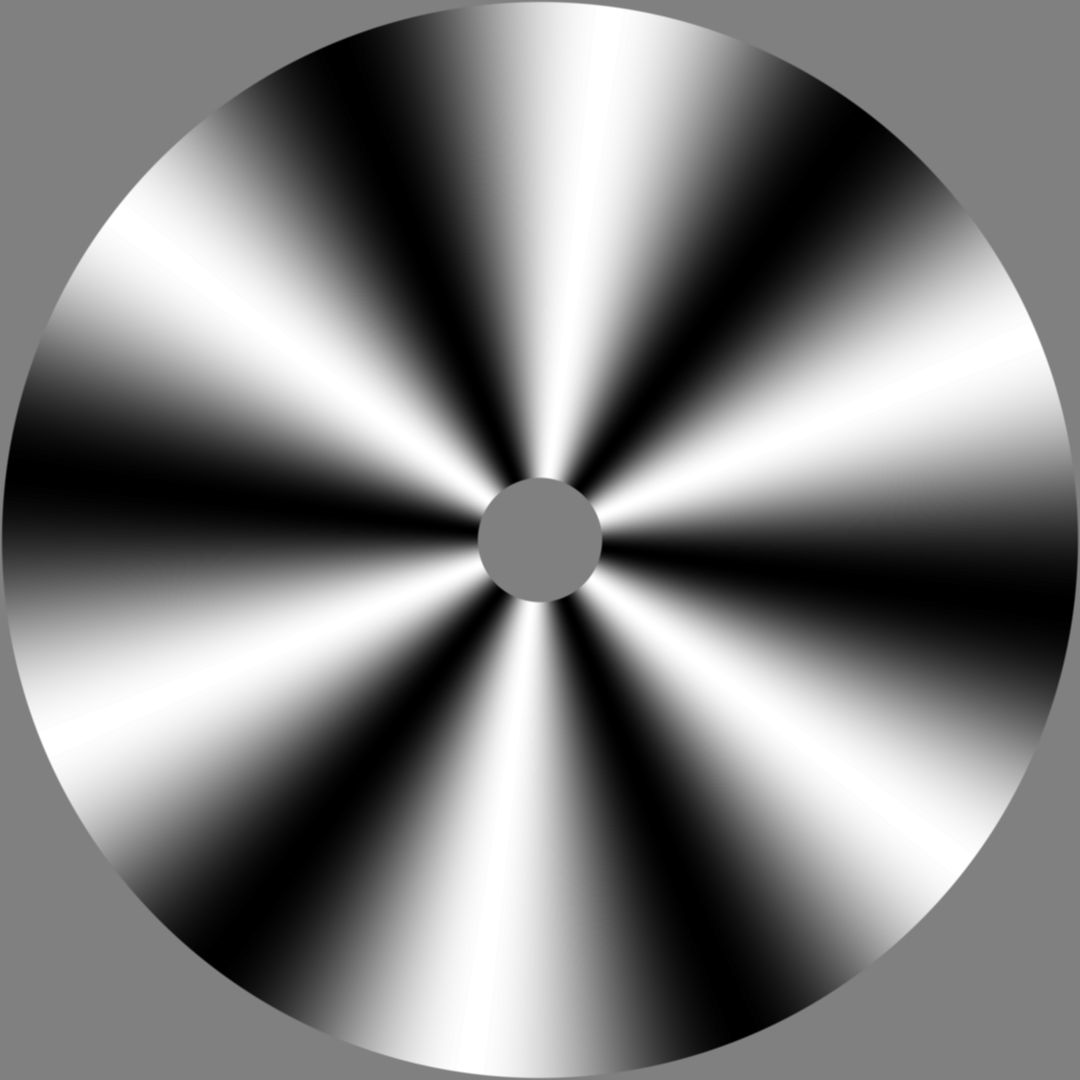
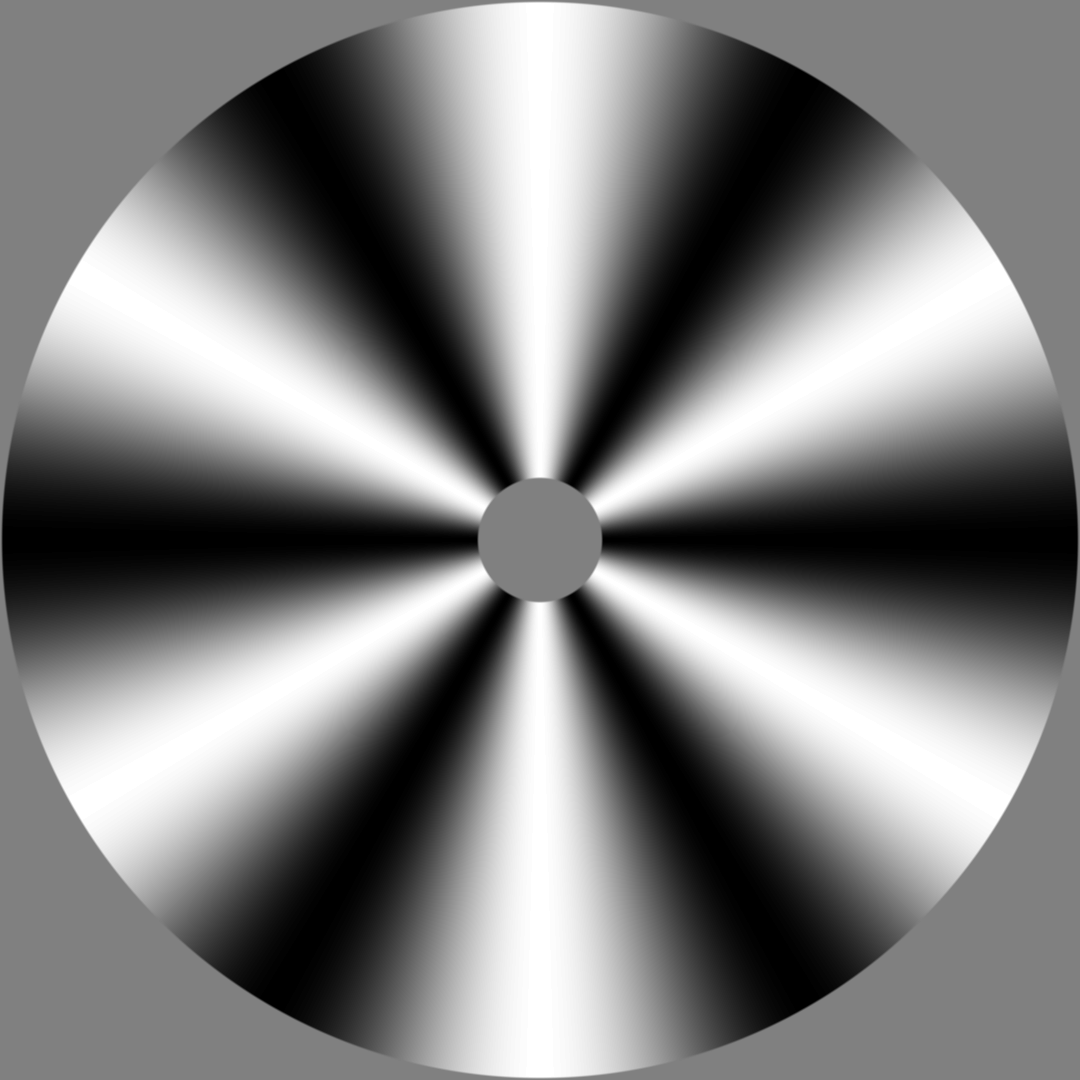
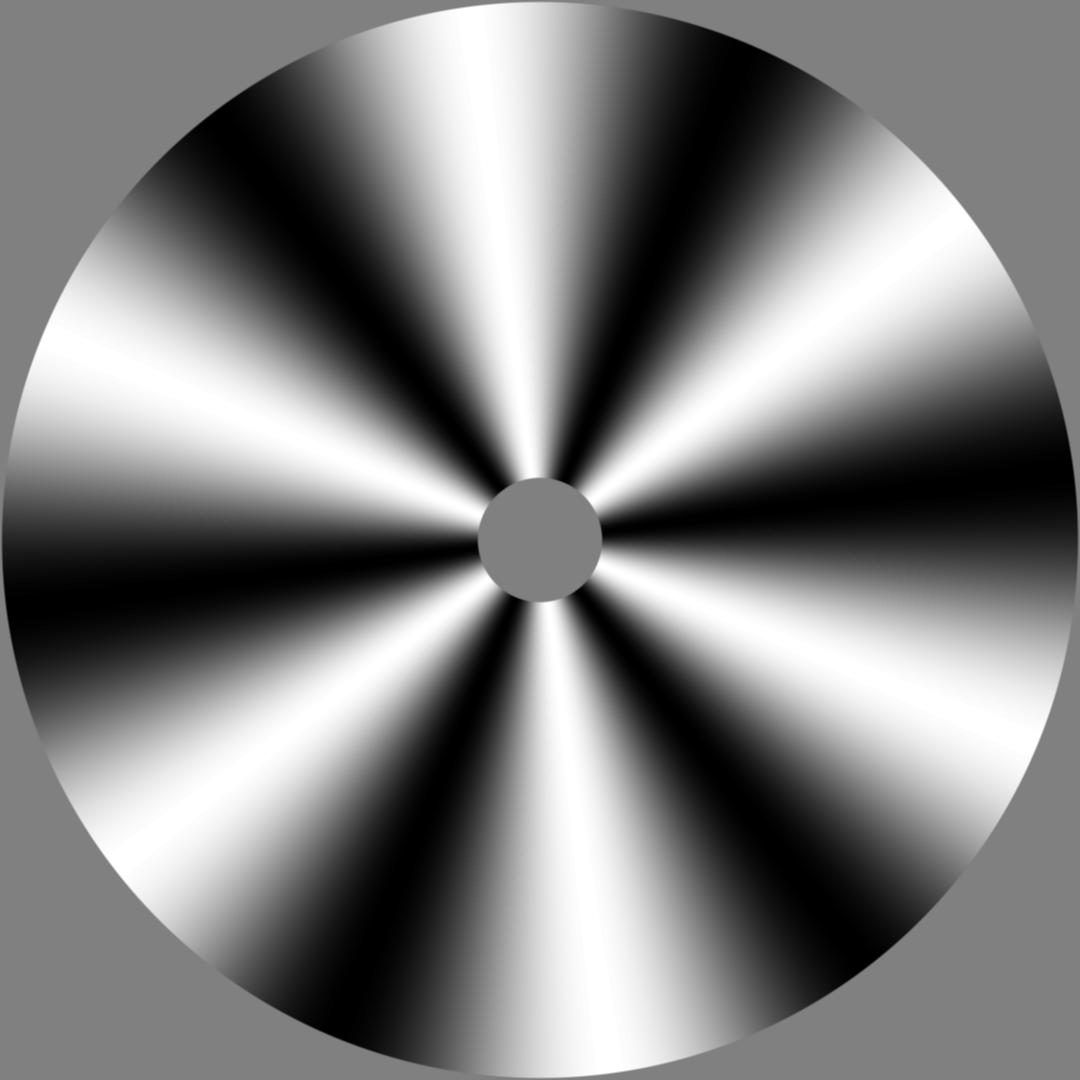
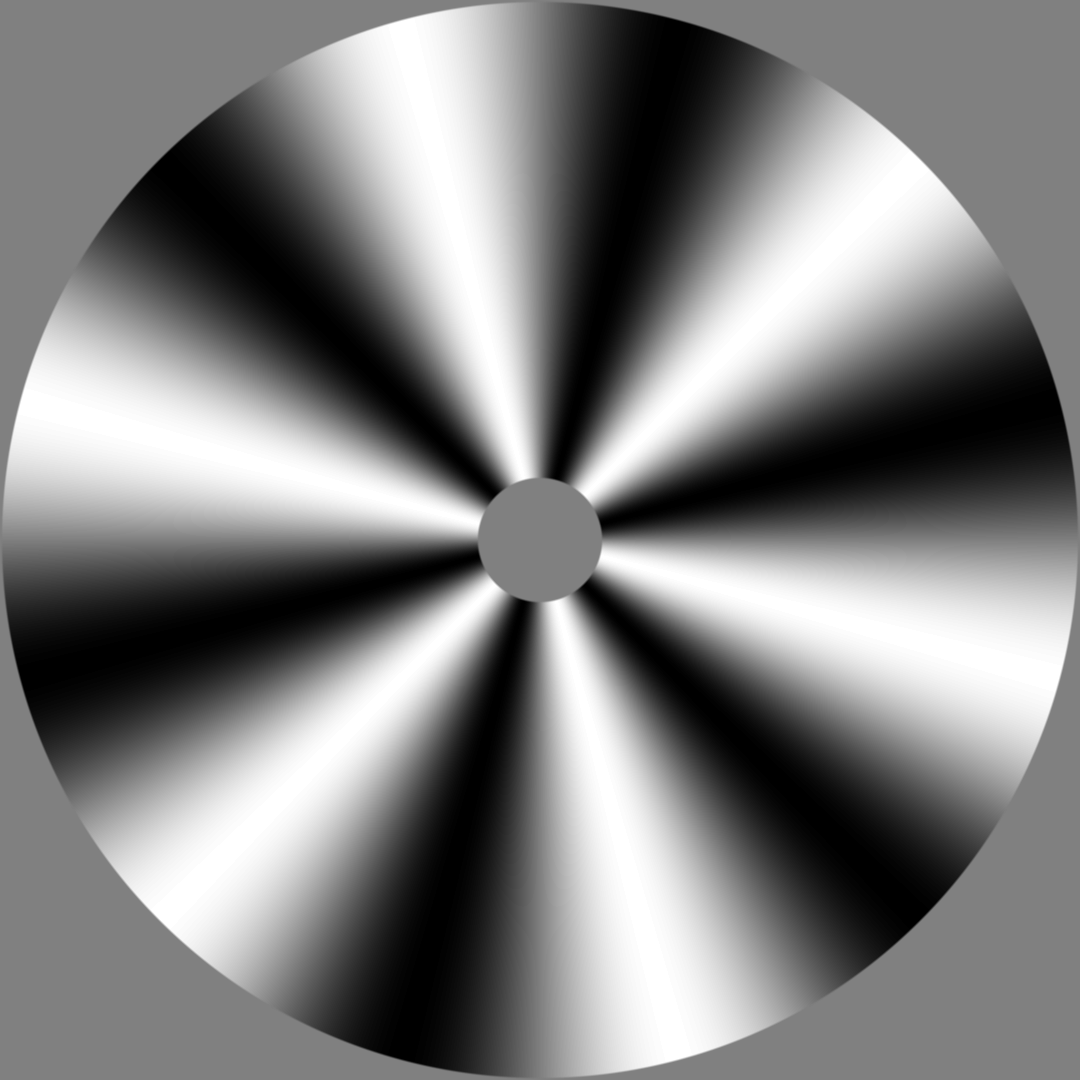
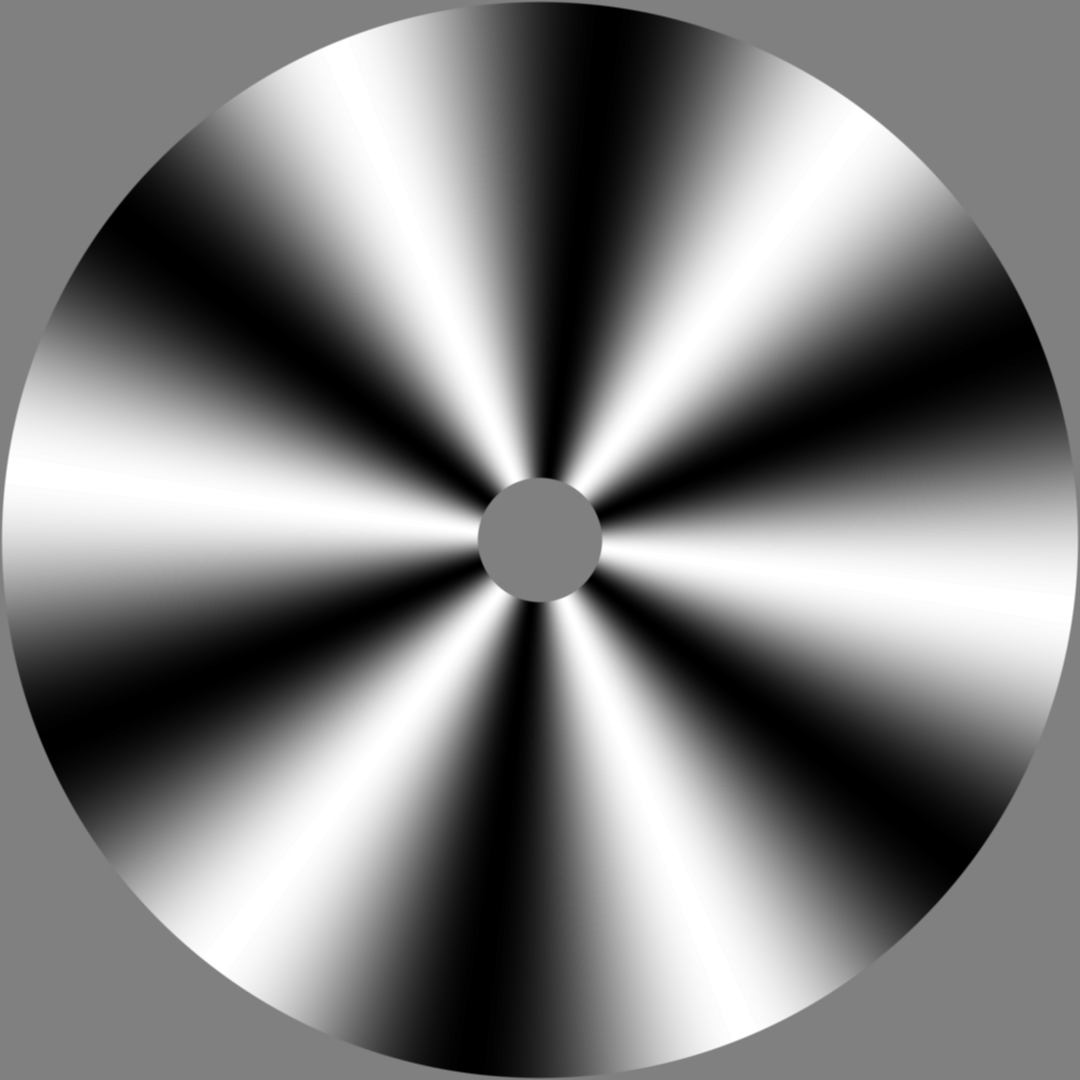
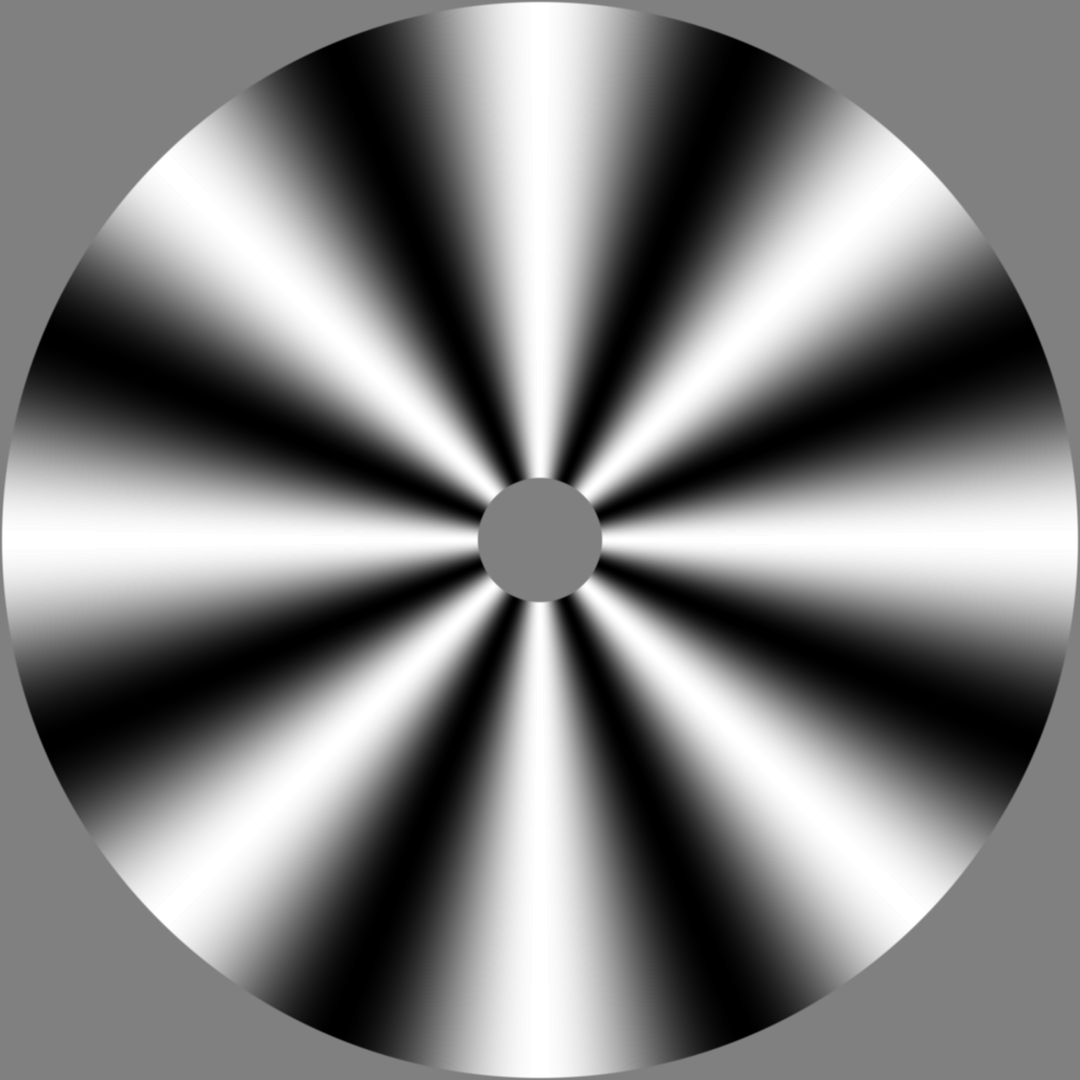
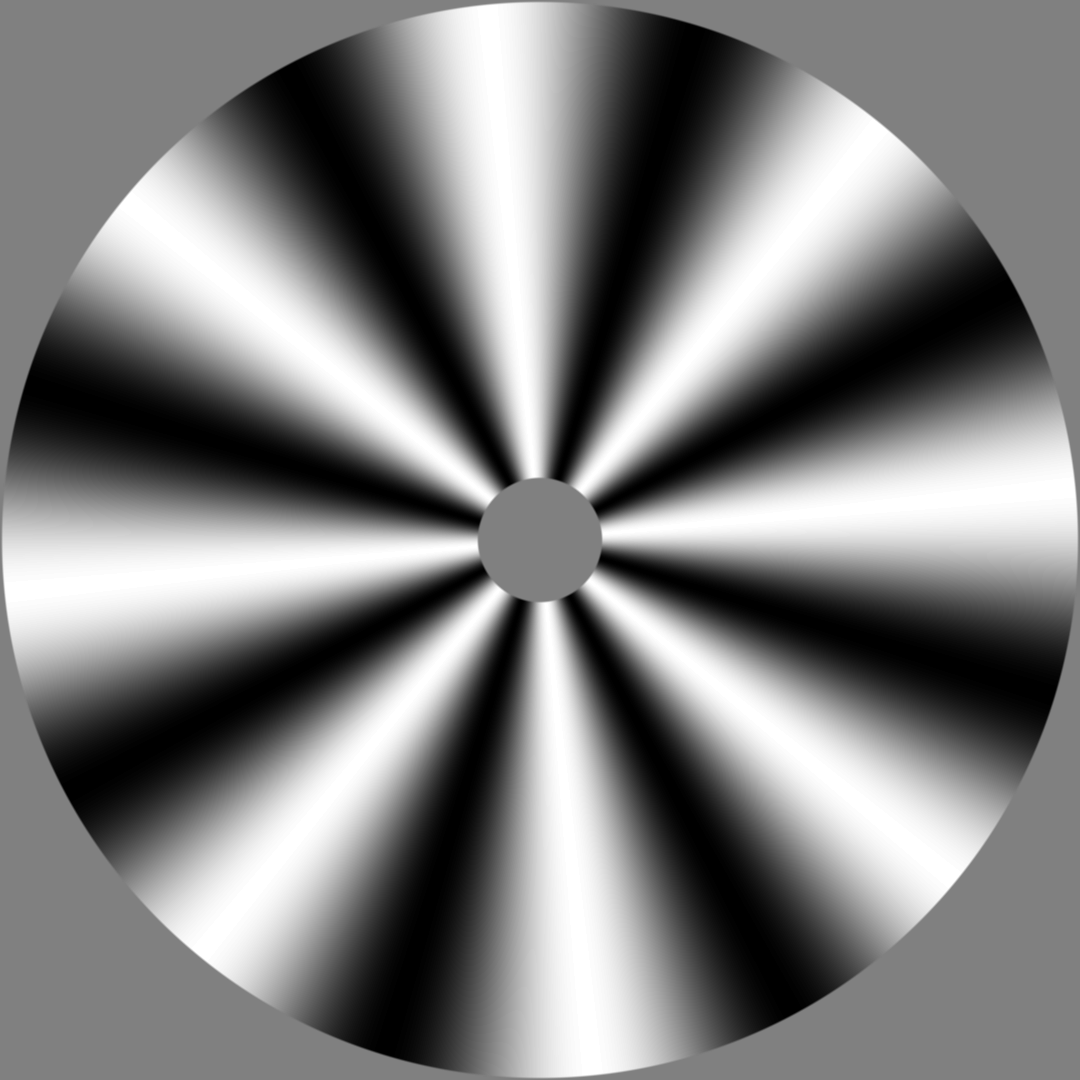

In [16]:
jbh.showIm([i for i in stim[:10]], ncols=4)


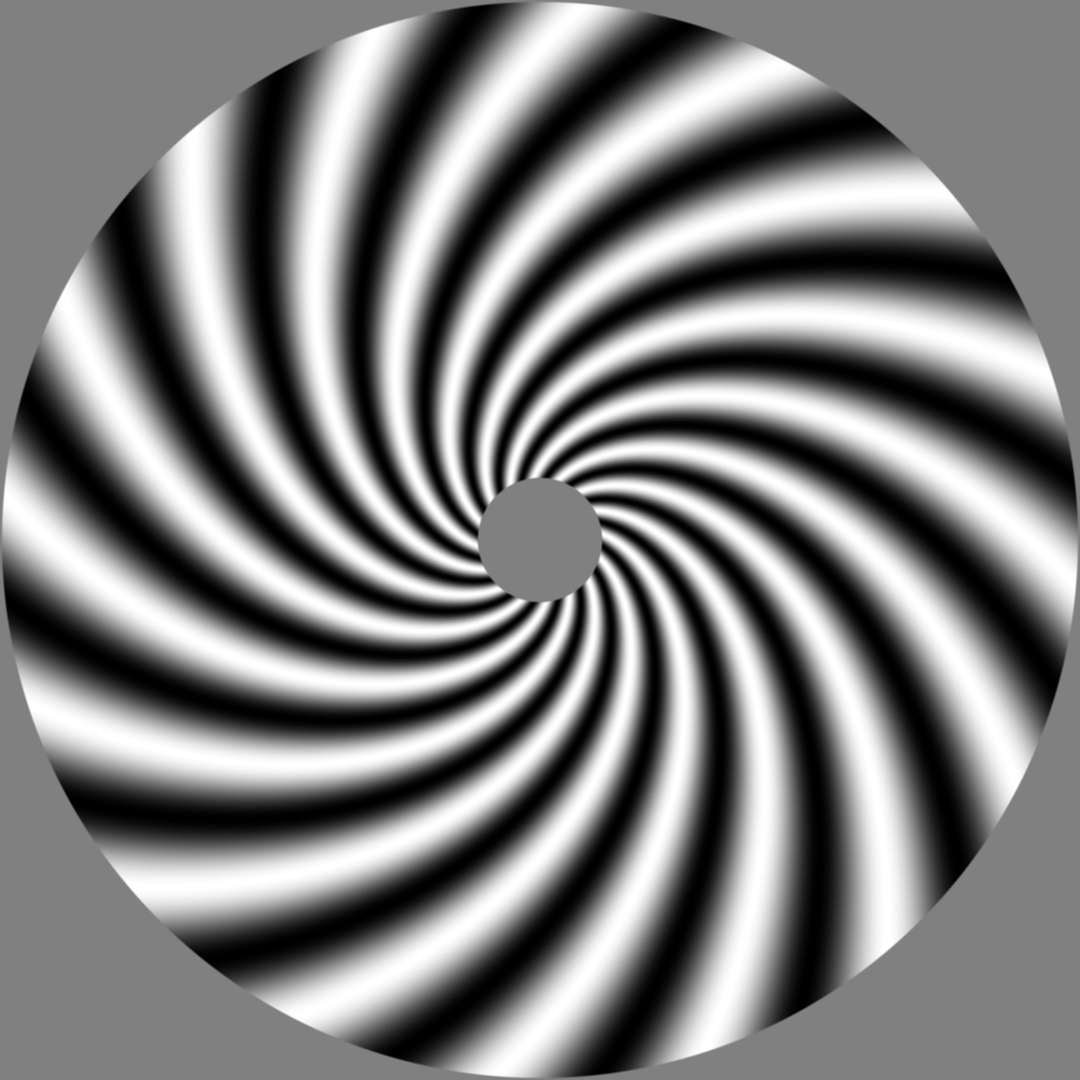
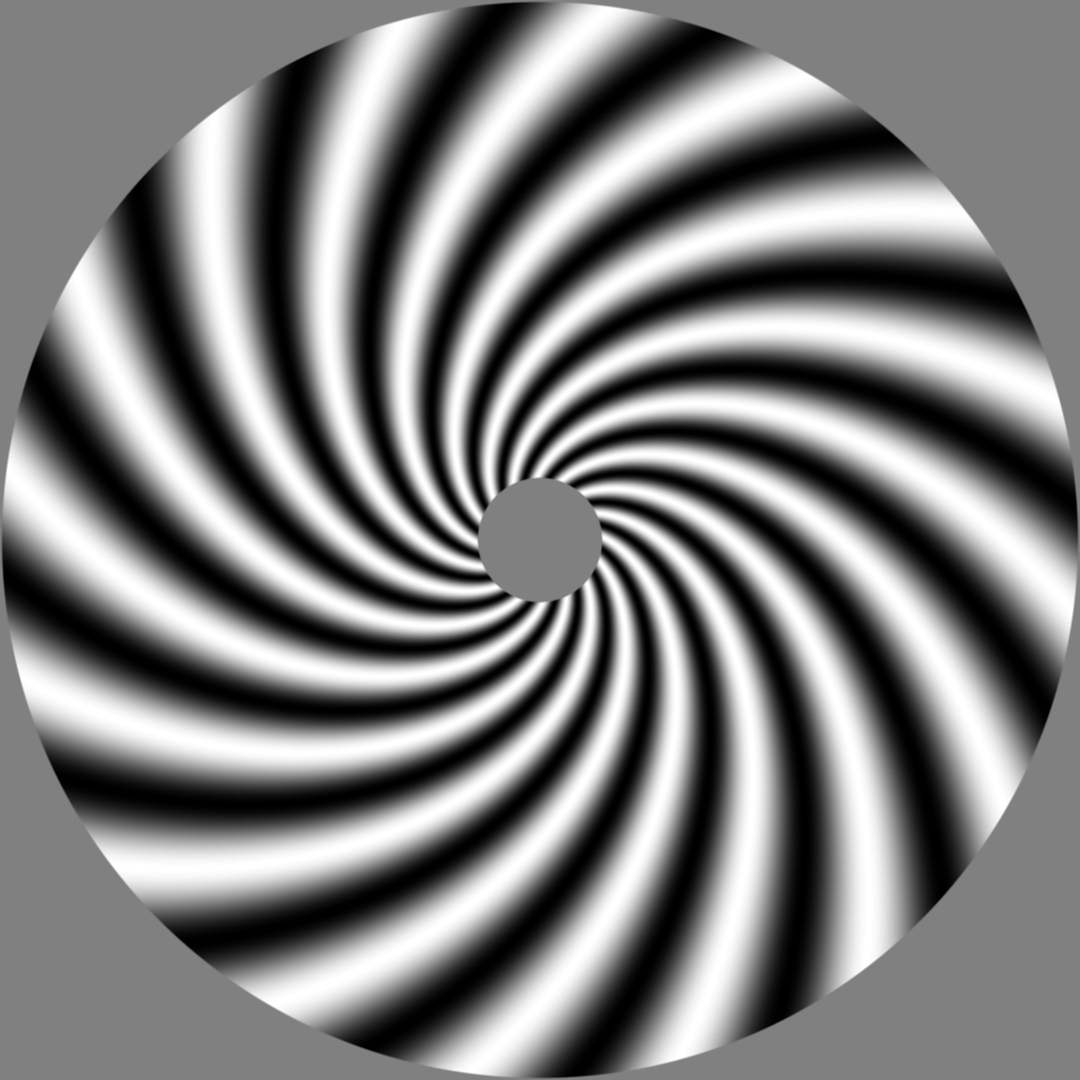
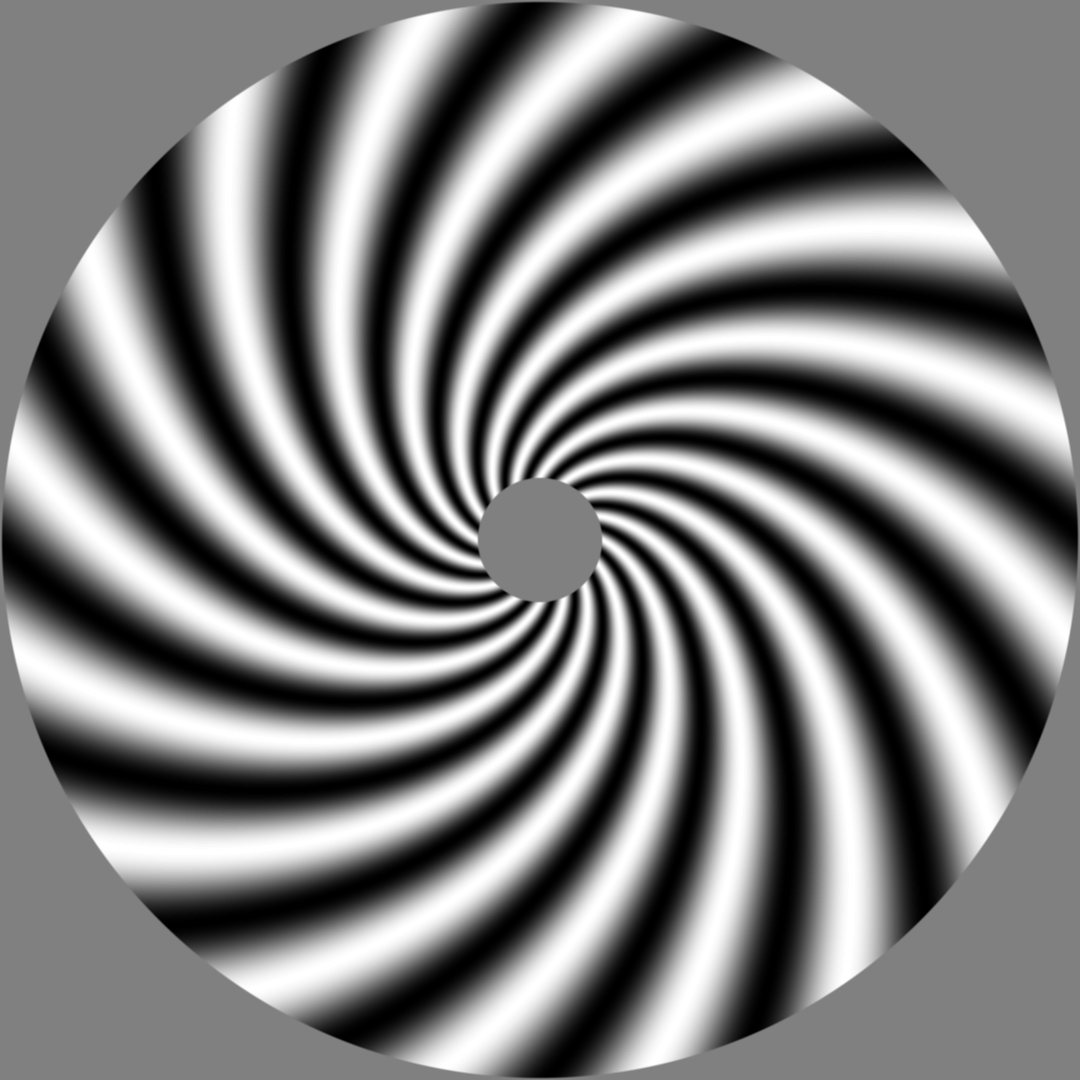
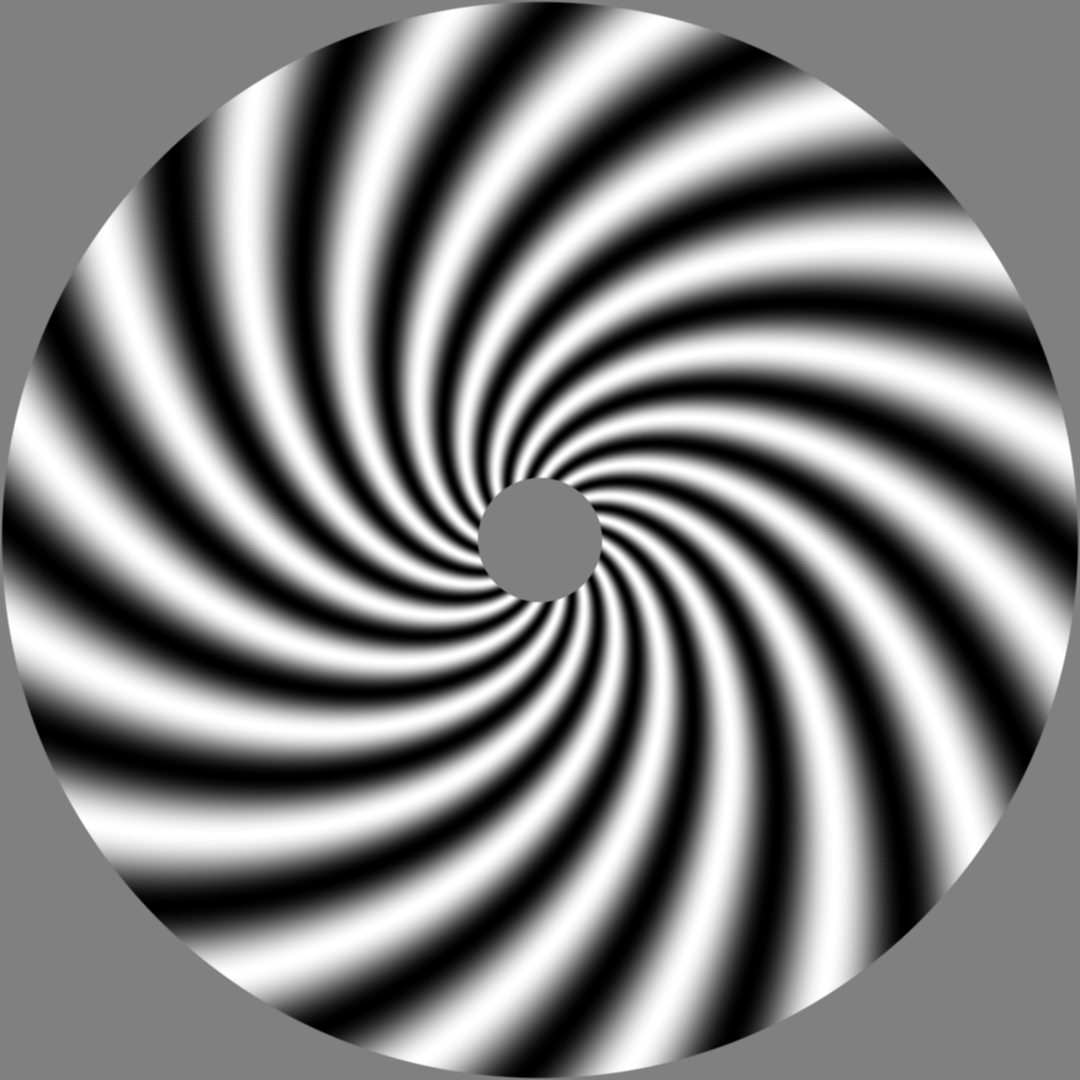

In [17]:
jbh.showIm([i for i in stim[300:304]], ncols=4)

Let's save some of these stimuli

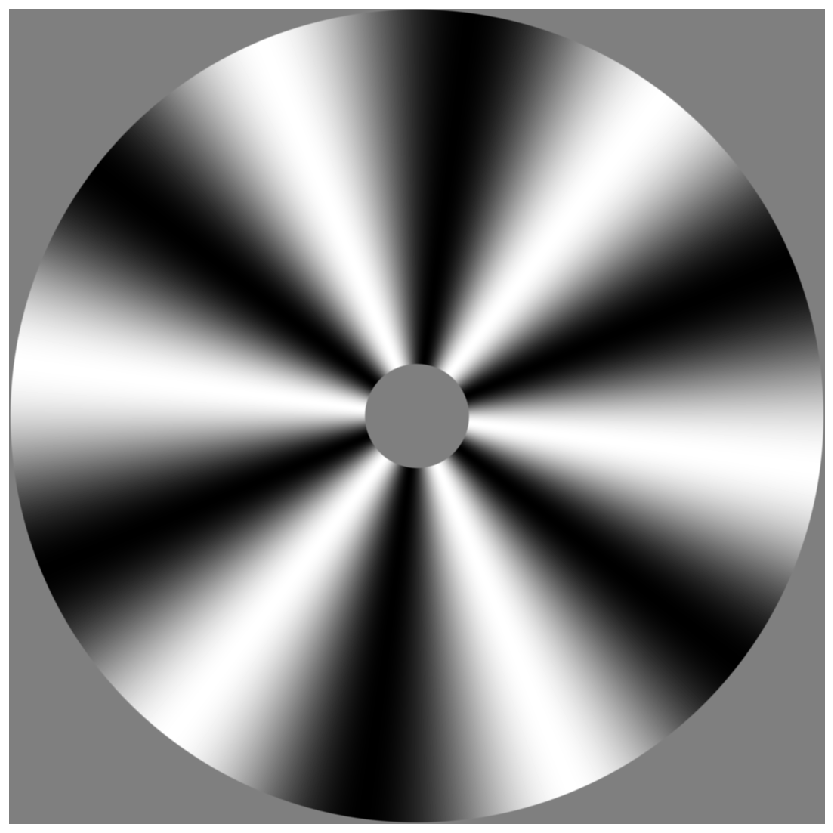

In [8]:
sns.plt.figure(figsize=(1080/90., 1080/90.), dpi=90)
for i, im in enumerate(stim[:8,:,:]):
    ax = sfp.utils.im_plot(im, vmin=0, vmax=255)
    ax.figure.savefig('stim_%01d_phases.svg' % i, bbox_inches='tight')

# Psychopy

The following blocks contain some code for experimenting with the psychopy presentation code and double-checking that they work. The experiment **should not** be run from here, but from the command-line instead.

However, we can demonstrate that the total length of the experiment and each individual block length is correct here.

In [7]:
keys, fix, tims, ps, idx = sfp.experiment.run("../data/stimuli/unshuffled.npy", "../data/stimuli_Noah/Noah_run00_idx.npy", session_length=40, save_frames='../data/stimuli_Noah/example-frames.png', fix_deg_size=.25)

438.0299 	WARNING 	Requested an unavailable screen number - using first available.
438.0302 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [1920, 1200]. Using actual size
438.7307 	ERROR 	Unknown colorSpace: None


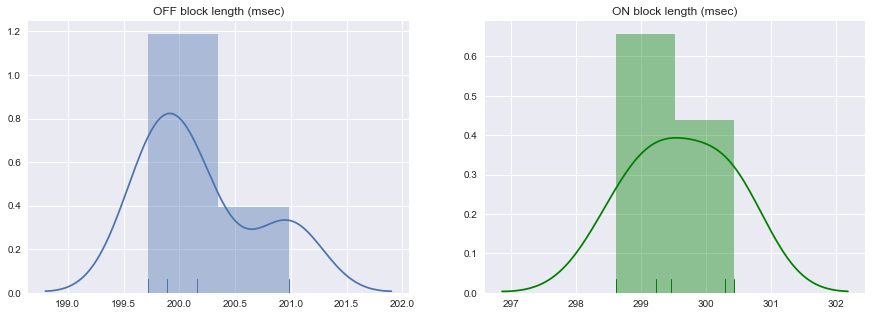

In [3]:
t = np.array([i[2] for i in tims])
t = (t[2:] - t[1:-1])*1000
fig, ax = sns.plt.subplots(1, 2, figsize=(15,5))
sns.distplot(t[1::2], rug=True, ax=ax[0])
ax[0].set_title("OFF block length (msec)")
sns.distplot(t[::2], rug=True, ax=ax[1], color='g')
ax[1].set_title("ON block length (msec)")

In [57]:
print("Total duration of experiment (in seconds): %.02f" % (tims[-1][2] - tims[0][2]))

Total duration of experiment (in seconds): 255.80


Use the following to test multiple trials, an experiment. Again, this is *only* for testing, to make sure that multiple trials line up and that the data is saved. It should not be used to run the actual experiment when scanning.

In [5]:
sfp.experiment.expt('../data/stimuli/unshuffled.npy', 2, 'Noah', session_length=None)

69.2775 	WARNING 	Requested an unavailable screen number - using first available.
69.2777 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [1920, 1200]. Using actual size
69.9176 	ERROR 	Unknown colorSpace: None
87.0402 	WARNING 	Requested an unavailable screen number - using first available.
87.0405 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [1920, 1200]. Using actual size
87.6469 	ERROR 	Unknown colorSpace: None
